# Synthetic Sonic Log Generation -- Yanxiang Yu 

* __Author__: _Yanxiang Yu_
* __Date__: February 26th, 2020


- <a>0. References</a>
    - <a> 0.1. Machine Learning for Subsurface Characterization
- <a>1. Introduction: Synthetic Sonic Curves Generation </a>
    - <a>1.1. Background</a>
    - <a>1.2. Problem Statement</a>
    - <a>1.3. Data Description</a>
    - <a>1.4. Evaluation Metric</a>
- <a>2. Imports</a>
- <a>3. Read in Data</a>
- <a>4. Glimpse of Data</a>
- <a>5. Exploratory Data Analysis</a>
- <a>6. Build Machine Models</a>
- <a>7. Prediction</a>
- <a>8. Summary</a>

<a></a>

## <a>0. References</a>

### <a>0.1. Machine Learning for Subsurface Characterization</a>

    https://books.google.com/books?hl=en&lr=&id=WdO1DwAAQBAJ&oi=fnd&pg=PA1&dq=Unsupervised+Outlier+Detection+Techniques+for+Well+Logs+and+Geophysical+Data&ots=bqx1qdGVIz&sig=6sUAVkNO4yxcD3NhszLhicyMMrc#v=onepage&q&f=false

## <a>1. Introduction: Synthetic Sonic Curves Generation</a>


### <a>1.1. Background</a>
Well logs are interpreted/processed to estimate the in-situ petrophysical and geomechanical properties, which is essential for subsurface characterization. Various types of logs exist, and each provides distinct information about subsurface properties. Certain well logs, like gamma ray (GR), resistivity, density, and neutron logs, are considered as “easy-to-acquire” conventional well logs that are run in most of the wells. Other well logs, like nuclear magnetic resonance, dielectric dispersion, elemental spectroscopy, and sometimes sonic logs, are only run in limited number of wells.

Sonic travel-time logs contain critical geomechanical information for subsurface characterization around the wellbore. Often, sonic logs are required to complete the well-seismic tie workflow or geomechanical properties prediction. When sonic logs are absent in a well or an interval, a common practice is to synthesize them based on its neighboring wells that have sonic logs. This is referred to as sonic log synthesis or pseudo sonic log generation.


### <a>1.2. Problem Statement</a>
Compressional travel-time (DTC) and shear travel-time (DTS) logs are not acquired in all the wells drilled in a field due to financial or operational constraints. Under such circumstances, machine learning techniques can be used to predict DTC and DTS logs to improve subsurface characterization. The goal of the “SPWLA’s 1st Petrophysical Data-Driven Analytics Contest” is to develop data-driven models by processing “easy-to-acquire” conventional logs from Well #1, and use the data-driven models to generate synthetic compressional and shear travel-time logs (DTC and DTS, respectively) in Well #2. A robust data-driven model for the desired sonic-log synthesis will result in low prediction errors, which can be quantified in terms of Root Mean Squared Error by comparing the synthesized and the original DTC and DTS logs.

You are provided with two datasets: train.csv and test.csv. You need to build a generalizable data-driven models using train dataset. Following that, you will deploy the newly developed data-driven models on test dataset to predict DTS and DTC logs. The data-driven model should use feature sets derived from the following 7 logs: Caliper, Neutron, Gamma Ray, Deep Resistivity, Medium Resistivity, Photo-electric factor and density. The data-driven model should synthesize two target logs: DTC and DTS logs.

The predicted values should be in the same format as sample_submission.csv, and submit together with your notebook for evaluation. 

### <a>1.3. Data Decription</a>
#### Files
&gt; #### train.csv
All the values equals to -999 are marked as missing values.
- CAL - Caliper, unit in Inch,  
- CNC - Neutron, unit in dec 
- GR - Gamma Ray, unit in API
- HRD - Deep Resisitivity, unit in Ohm per meter,
- HRM - Medium Resistivity, unit in Ohm per meter,
- PE - Photo-electric Factor, unit in Barn,
- ZDEN - Density, unit in Gram per cubit meter, 
- DTC - Compressional Travel-time, unit in nanosecond per foot,
- DTS - Shear Travel-time, unit in nanosecond per foot,


&gt; #### test.csv
The test data has all features that you used in the train dataset, except the two sonic curves DTC and DTS.

&gt; ####  sample_submission.csv
A valid sample submission.
<p><font style="">
</font></p>

### <a>1.4. Evaluation Metric</a>
We will be evaluated by the metirc `Root Mean Squared Error`.

The RMSE is calculated as:

$ ϵ=∑_i \sqrt{ ∑_n (y_p - y_t)^2 /n } $

Where:
- y_p is the predicted curve for DTC and DTS
- y_t is the true value for evaluation.

DTC and DTS are in the same weight during the evaluation 

Understanding and optimizing your predictions for this evaluation metric is paramount for this compeition.

## <a>2. Imports</a>

<a>Top</a>

In [1]:
# import libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
# import sklearn libararies
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.neural_network import MLPRegressor
import matplotlib.style as style

from scipy import stats
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

# Use some functions from tensorflow_docs
# pip install -q git+https://github.com/tensorflow/docs
    
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

style.available

style.use('seaborn-dark')
# plt.style.use('ggplot')

2.1.0


## <a>3. Read Data</a>

<a>Top</a>

In [2]:
df1 = pd.read_csv('train.csv')

## <a>4. Glimps Data</a>

<a>Top</a>

In [3]:
df1.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000
mean,-8.394576,-23.692615,38.959845,3.977690,1.547299,-17.446739,-20.229982,-54.891703,-9.737567
std,129.970219,157.142679,108.504554,365.112753,456.908969,149.083136,148.809506,372.858812,440.314119
min,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
25%,8.058350,0.122800,17.248750,0.717700,0.712050,0.053100,2.226700,66.304350,118.534350
50%,8.625000,0.193600,36.821800,1.623000,1.628100,4.941500,2.432200,78.355100,137.689300
75%,9.048850,0.337150,58.346150,3.158300,3.280600,7.856650,2.551350,107.022500,182.973150
max,21.064200,3490.158200,1470.253400,10000.000000,60467.761700,28.106400,3.259700,155.980300,487.438400


In [4]:
df1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30143 entries, 0 to 30142
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CAL     30143 non-null  float64
 1   CNC     30143 non-null  float64
 2   GR      30143 non-null  float64
 3   HRD     30143 non-null  float64
 4   HRM     30143 non-null  float64
 5   PE      30143 non-null  float64
 6   ZDEN    30143 non-null  float64
 7   DTC     30143 non-null  float64
 8   DTS     30143 non-null  float64
dtypes: float64(9)
memory usage: 2.1 MB


## <a>5. Exploratory Data Analysis</a>

<a>Top</a>

Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, missing values, outliers, anomalies, patterns, or relationships within the data. 

In [5]:
# Replace all -999 with nan value
df1.replace(['-999', -999], np.nan, inplace=True)
df1.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,29633.000000,29408.000000,29889.000000,29758.000000,29758.000000,29464.000000,29462.000000,26089.000000,25278.000000
mean,8.654281,0.683437,47.780541,16.953912,14.492077,5.173227,2.393818,91.814381,180.655730
std,1.749145,30.689679,51.377519,349.067878,445.361622,4.781088,0.196276,24.337910,81.141960
min,5.930400,-0.102800,-0.146000,0.054100,0.061600,-0.023200,-1.923800,49.970500,80.580400
25%,8.135600,0.127100,18.026100,0.740450,0.734700,0.054200,2.234800,71.357000,129.446625
50%,8.625000,0.198500,37.082200,1.662750,1.665150,5.042500,2.439600,85.237600,144.593050
75%,9.063000,0.343100,58.532800,3.180350,3.308900,7.949700,2.553000,112.112600,191.475125
max,21.064200,3490.158200,1470.253400,10000.000000,60467.761700,28.106400,3.259700,155.980300,487.438400


In [6]:
# Plot well logs
def log_plot(z, log, x_label='', y_label='Sample', title=''):
    plt.plot(log, z)
    plt.ylim(z.max(), z.min())
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.tick_params(labeltop=True, labelright=True)

In [7]:
# load test data from well 2
df2 = pd.read_csv('test.csv')

# Remove missing 
for col in df2.columns.tolist():
    df2[col][df2[col]==-999] = np.nan

df2.dropna(axis=0, inplace=True)
df2.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN
count,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000
mean,8.634049,0.158501,28.966414,4.028372,106.752210,7.353522,2.475884
std,0.044064,0.091298,43.648163,7.198112,2374.620246,1.239075,0.149440
min,8.500000,0.009800,0.852000,0.083900,0.102700,4.760800,2.033400
25%,8.625000,0.091700,8.449450,1.760775,1.865575,6.528075,2.378175
50%,8.625000,0.128300,18.168650,2.758900,3.176950,7.881700,2.533600
75%,8.671900,0.213500,36.470725,4.539675,5.034600,8.308325,2.581800
max,8.875000,0.559400,1124.442000,202.233000,62290.769500,13.840700,3.024800


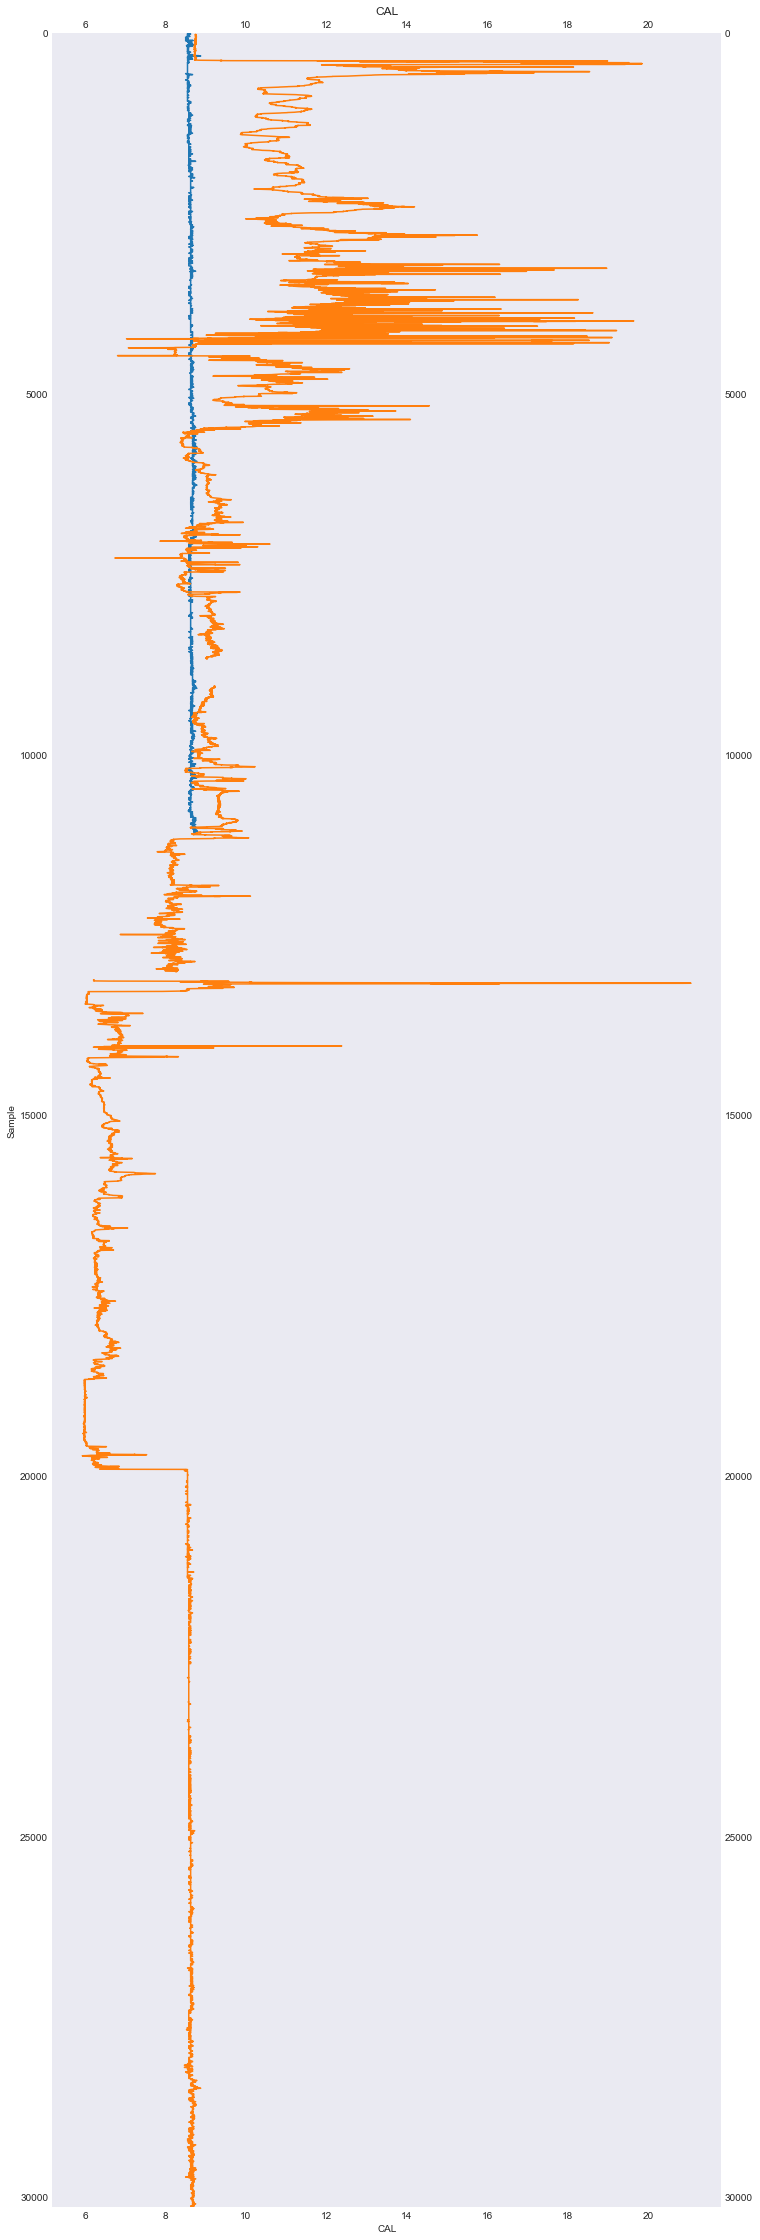

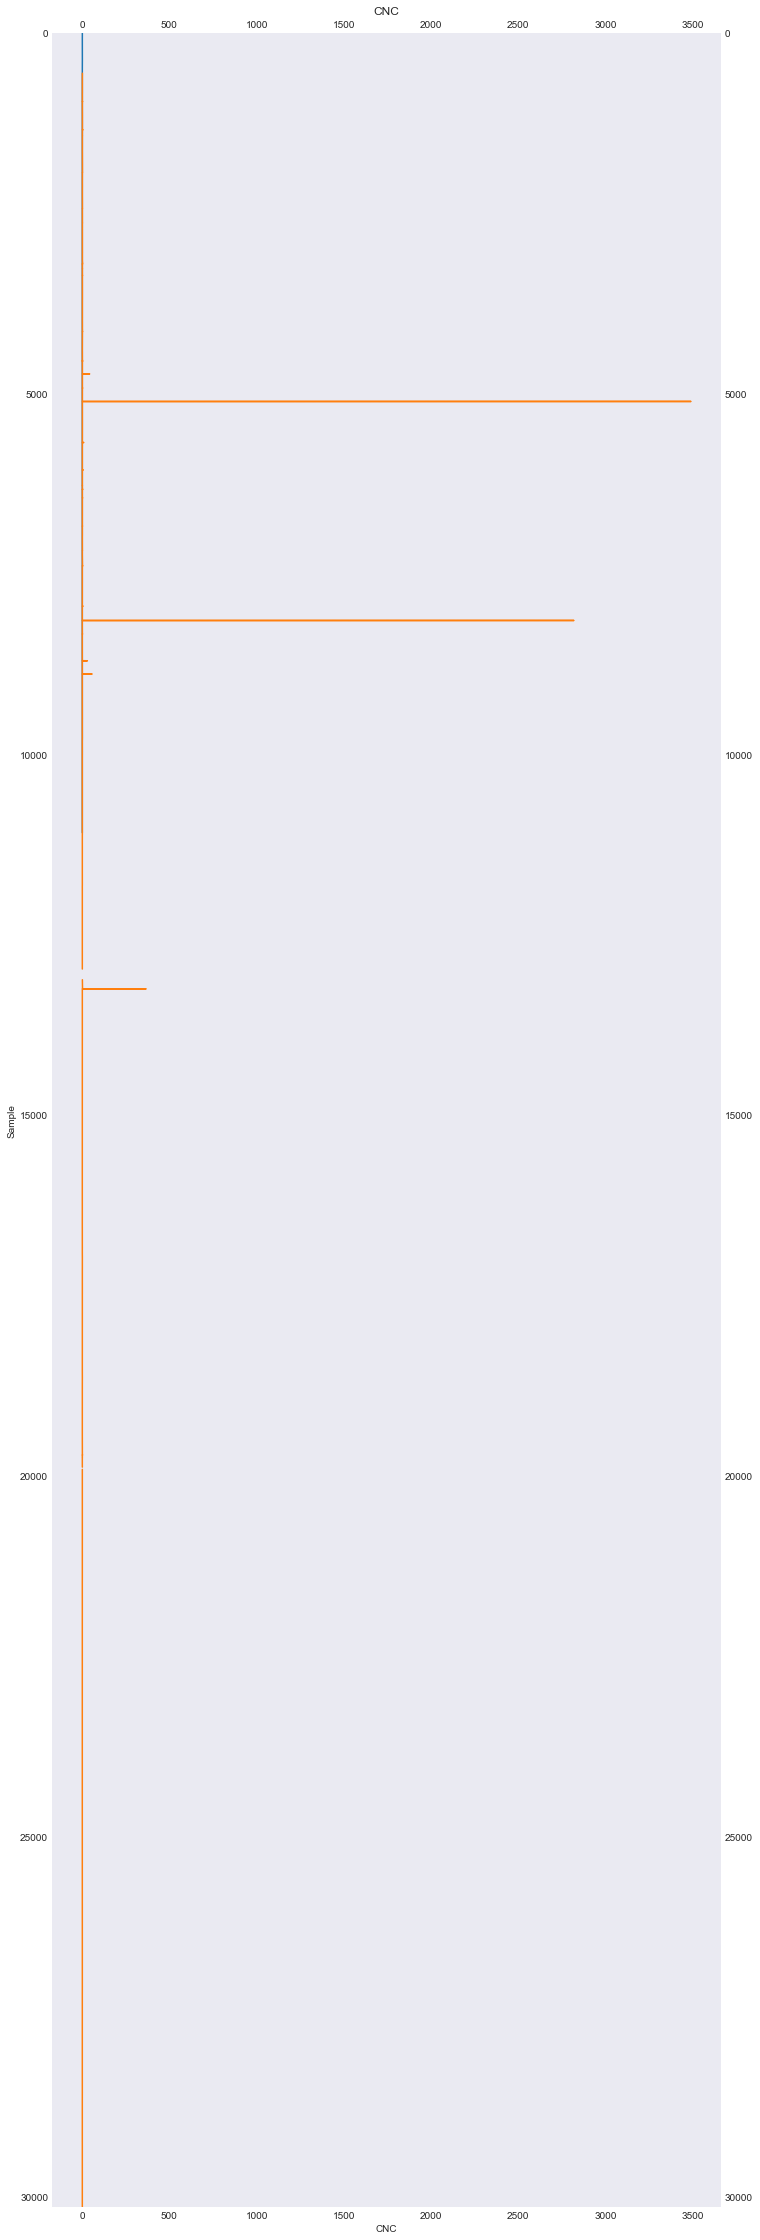

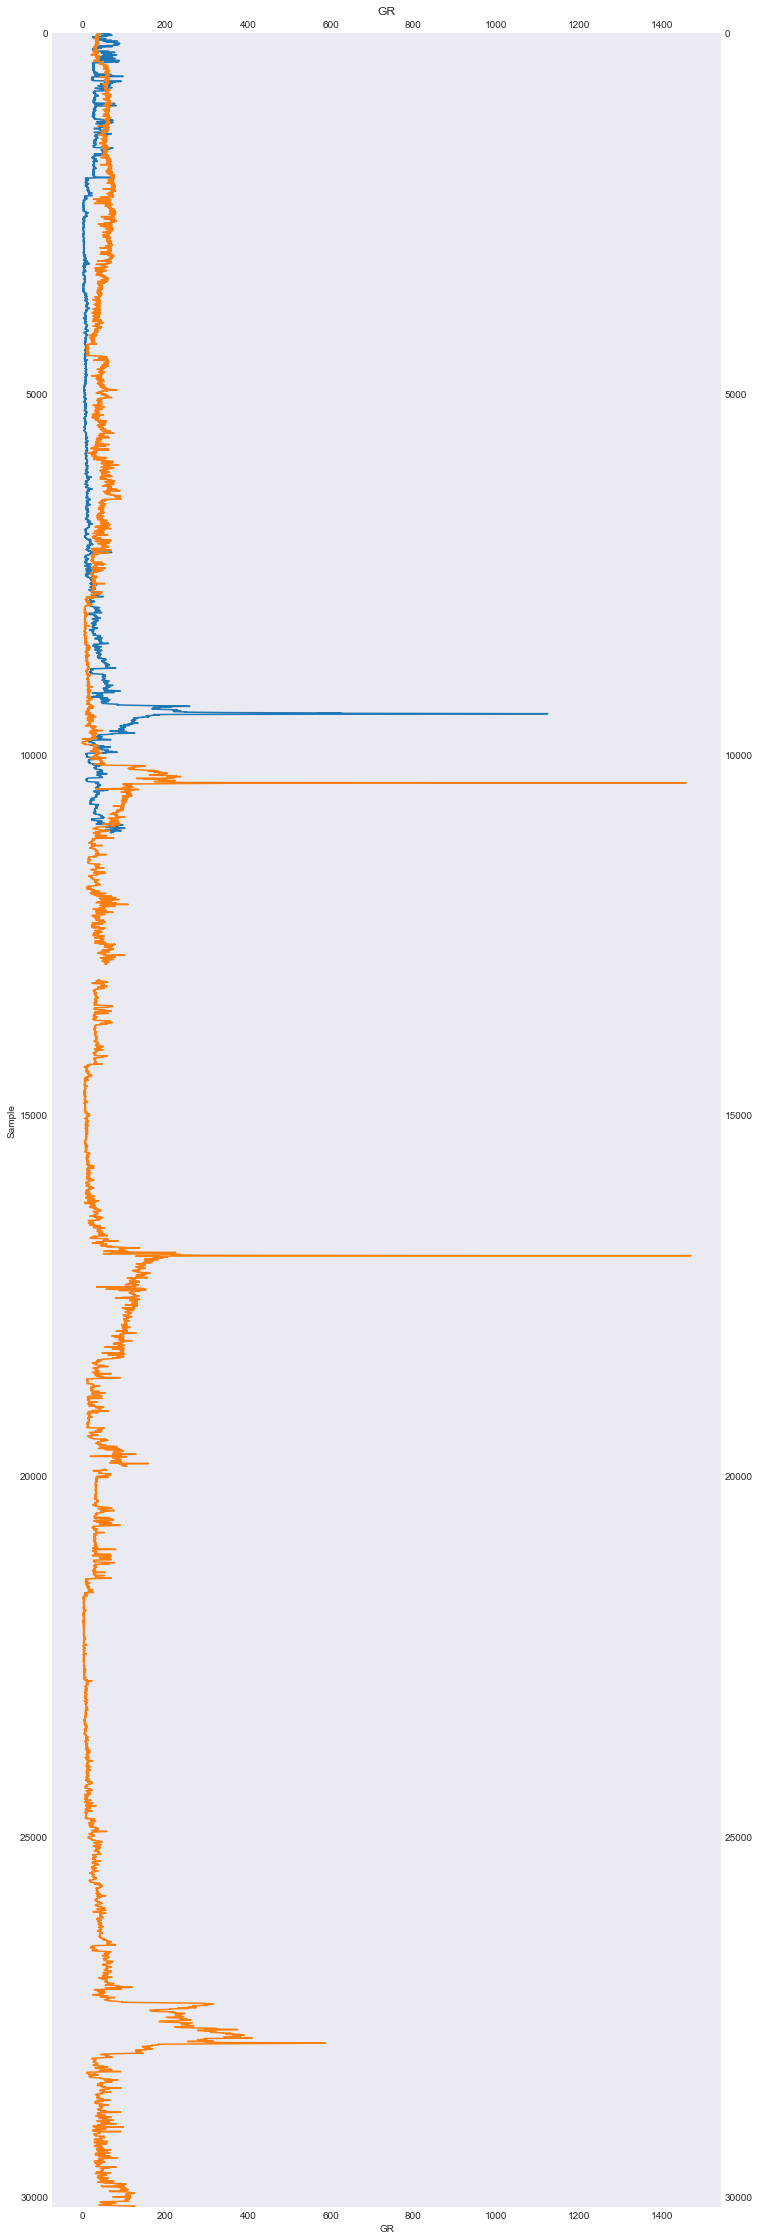

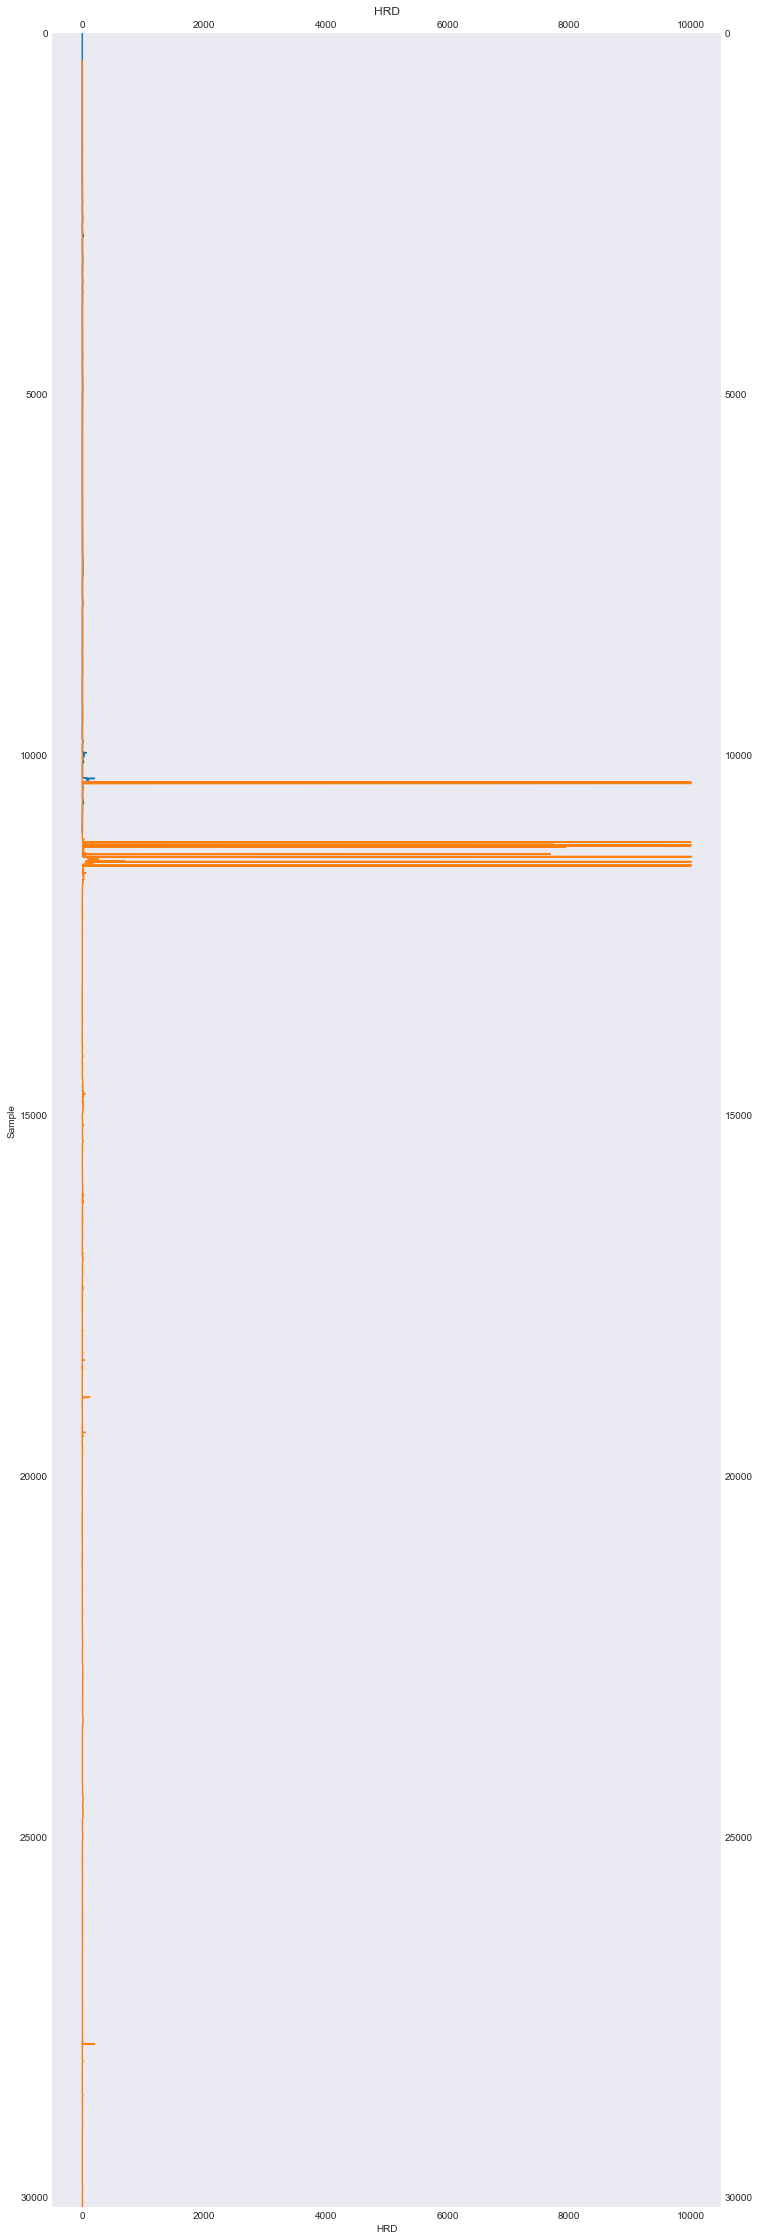

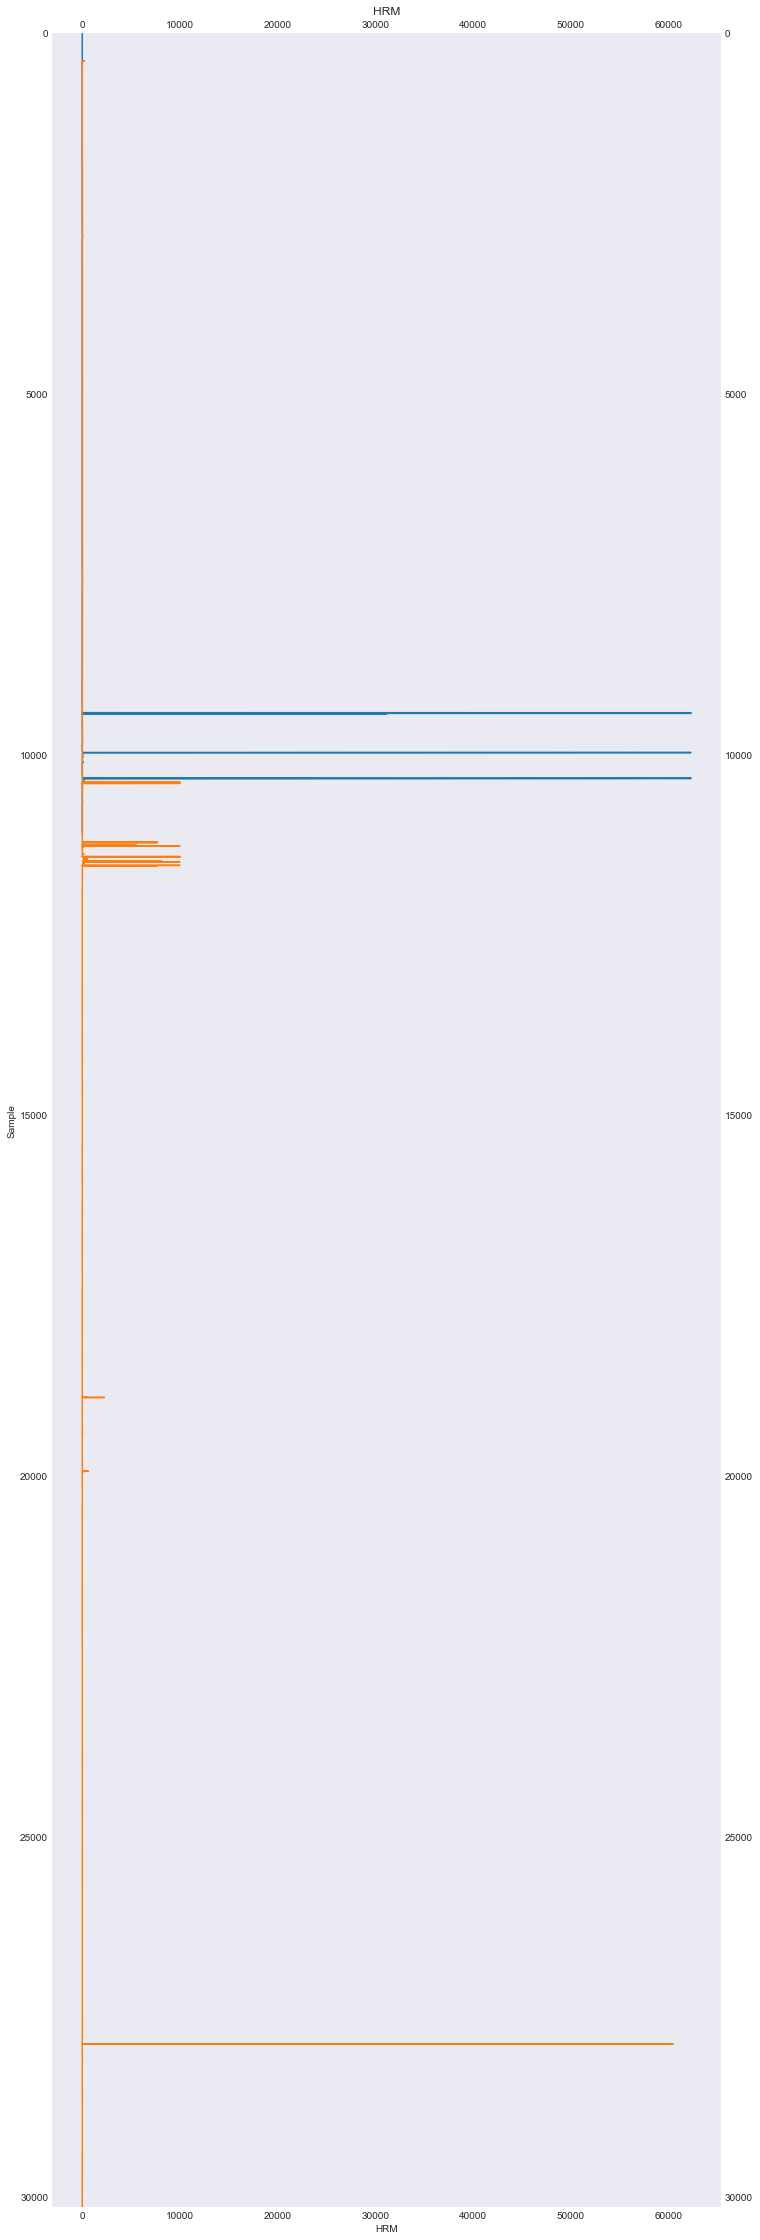

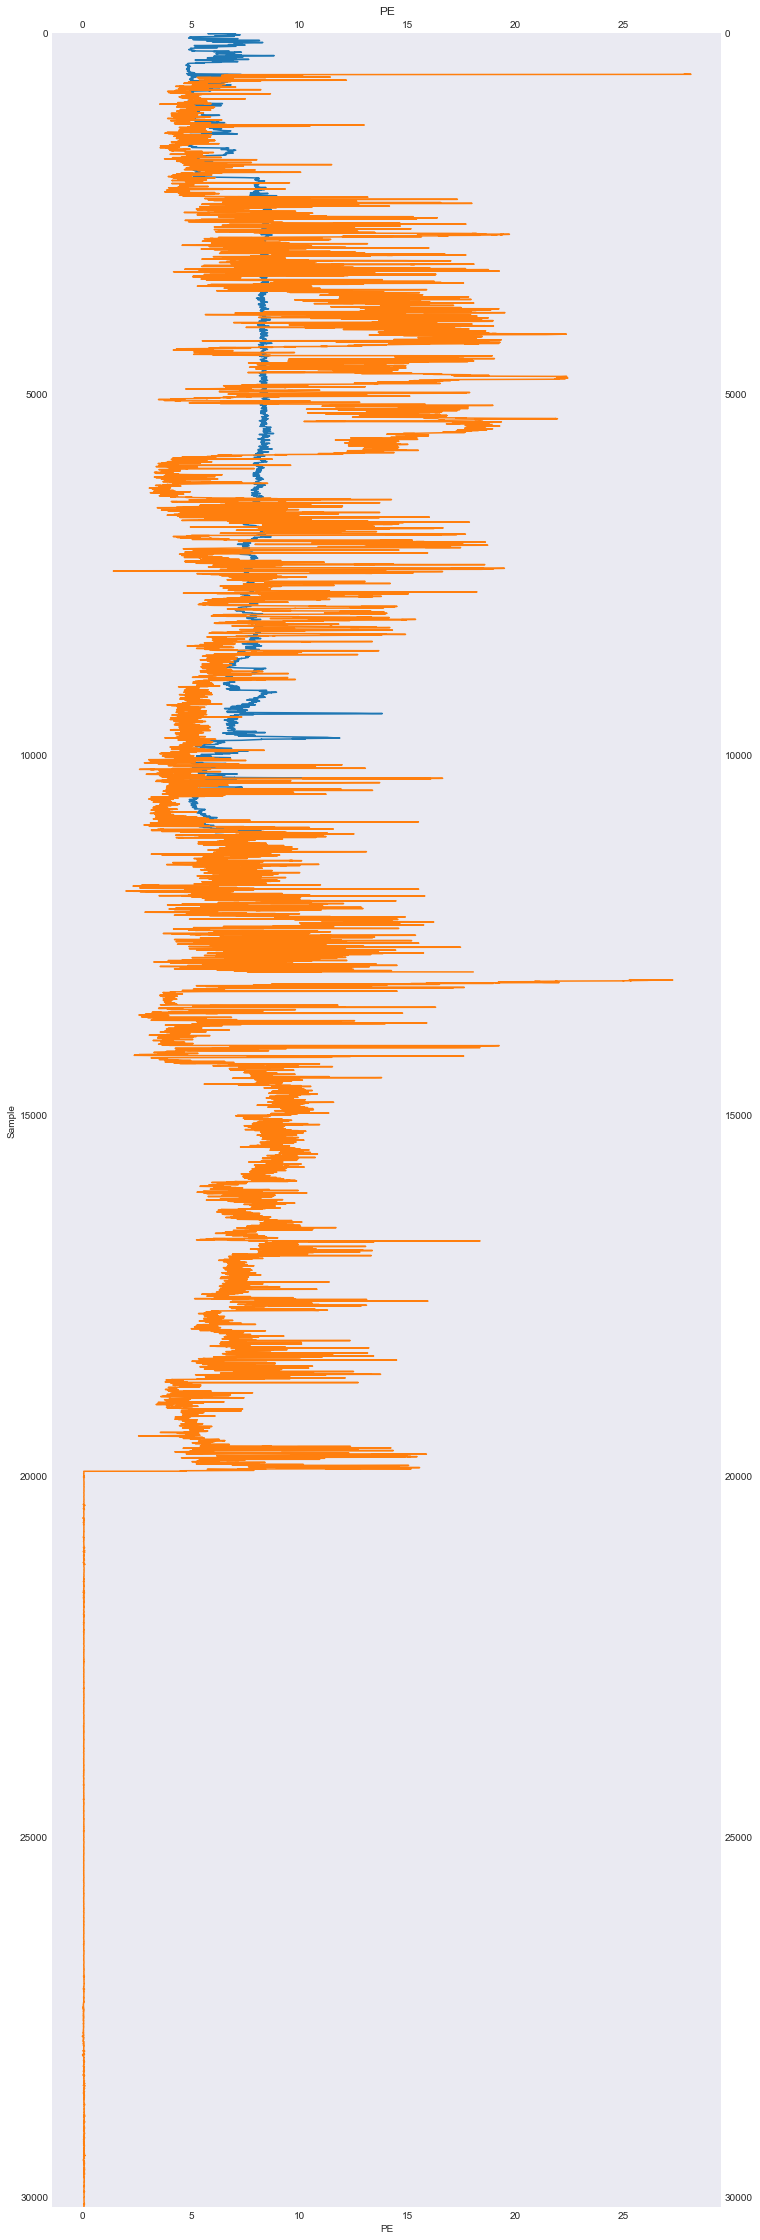

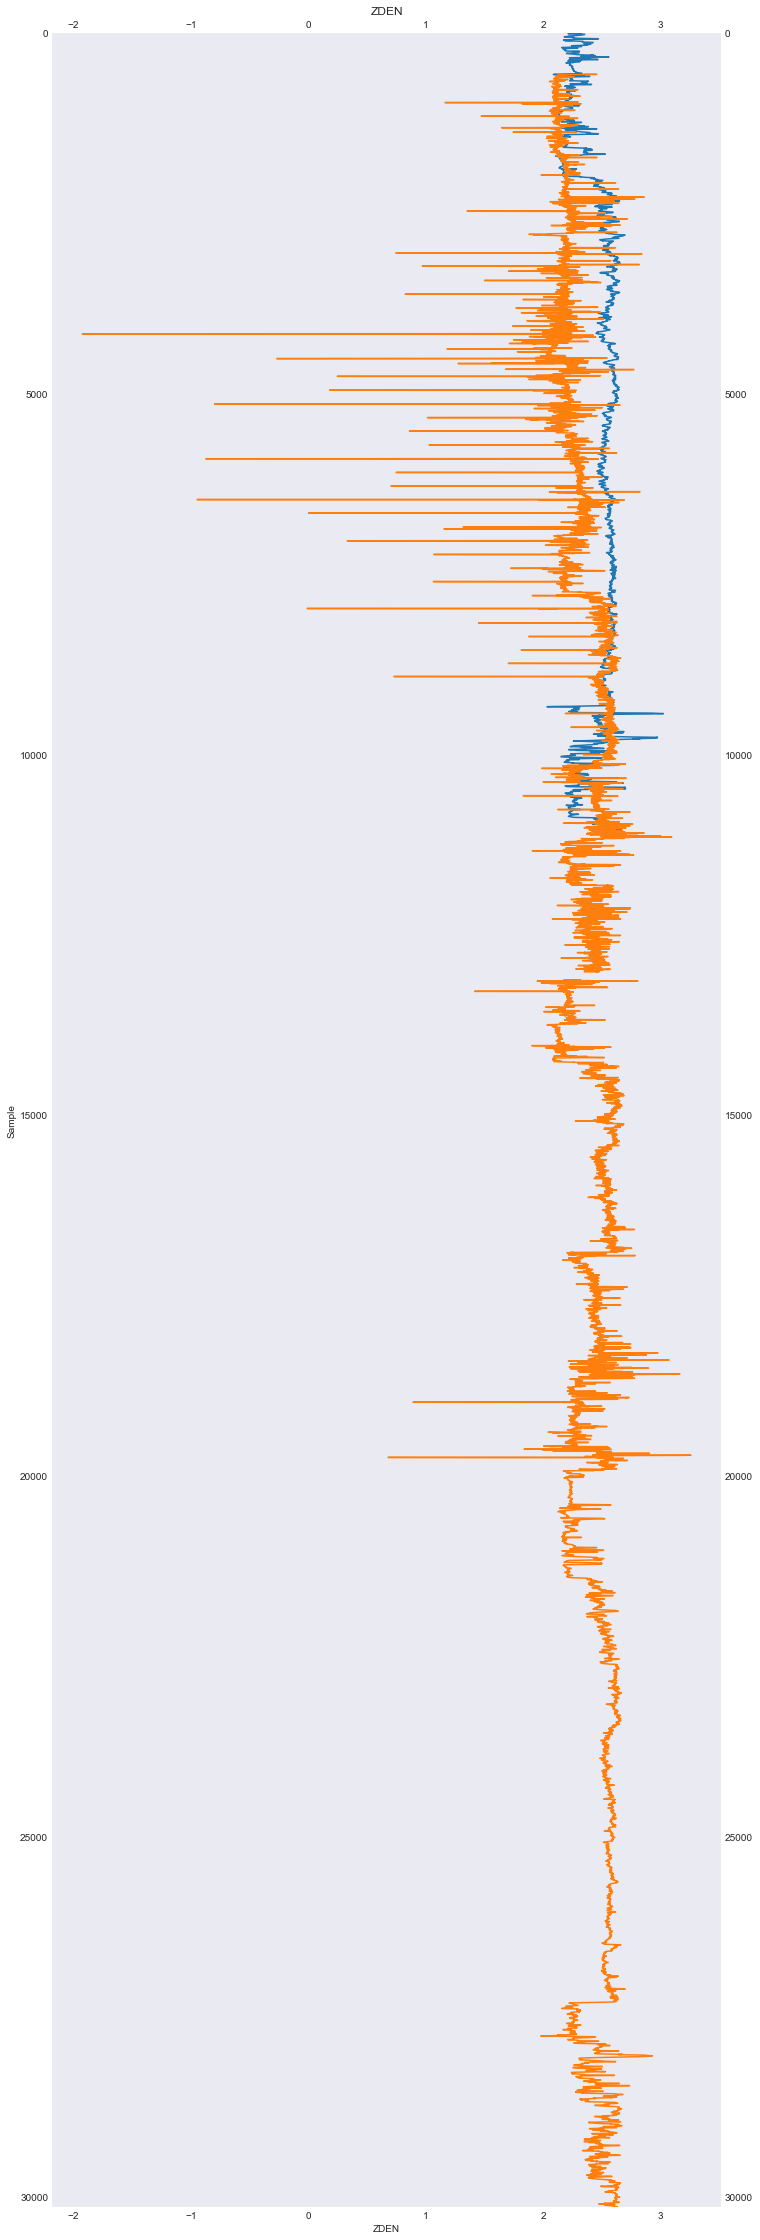

In [8]:
# Insert index as depth column
# df1.insert(0, 'DEP', df1.index) 

logs = df1.columns.tolist()

matplotlib.rcParams['figure.figsize'] = (16.0, 9.0)

for i, item in enumerate(logs[:-2]):
    plt.figure(figsize=(12.0, 40.0))
    log_plot(df2.index, df2[item])
    log_plot(df1.index, df1[item], item, title=item)
    # plt.figure()
    # plt.plot(df1[item], df1.index)
    # plt.ylim(df1.index.max(), df1.index.min())
    # plt.scatter(df1.index, df1[item], s=2)
    # plt.title( item + ', # of nan = ' + str(df1[item].isna().sum()) )

In [9]:
# for i, item in enumerate(logs[-2:]):
#     plt.scatter( df1.index, df1[item], s=2, label=item + ', # of nan = ' + str(df1[item].isna().sum()) )
# plt.legend()

In [10]:
# fig, ax1 = plt.subplots()

# color = 'tab:red'
# ax1.set_xlabel('point')
# ax1.set_ylabel('CAL', color=color)
# ax1.scatter(df1.index, df1['CAL'], color=color, s=2)
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('CNC', color=color)  # we already handled the x-label with ax1
# ax2.scatter(df1.index, df1['CNC'], color=color, s=2)
# ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped

In [11]:
print(df1.shape)

# remove all rows that contains missing value
df1.dropna(axis=0, inplace=True)

print(df1.shape)

(30143, 9)
(20525, 9)


method =  1 :  One-Class SVM
Number of anomalies =  26


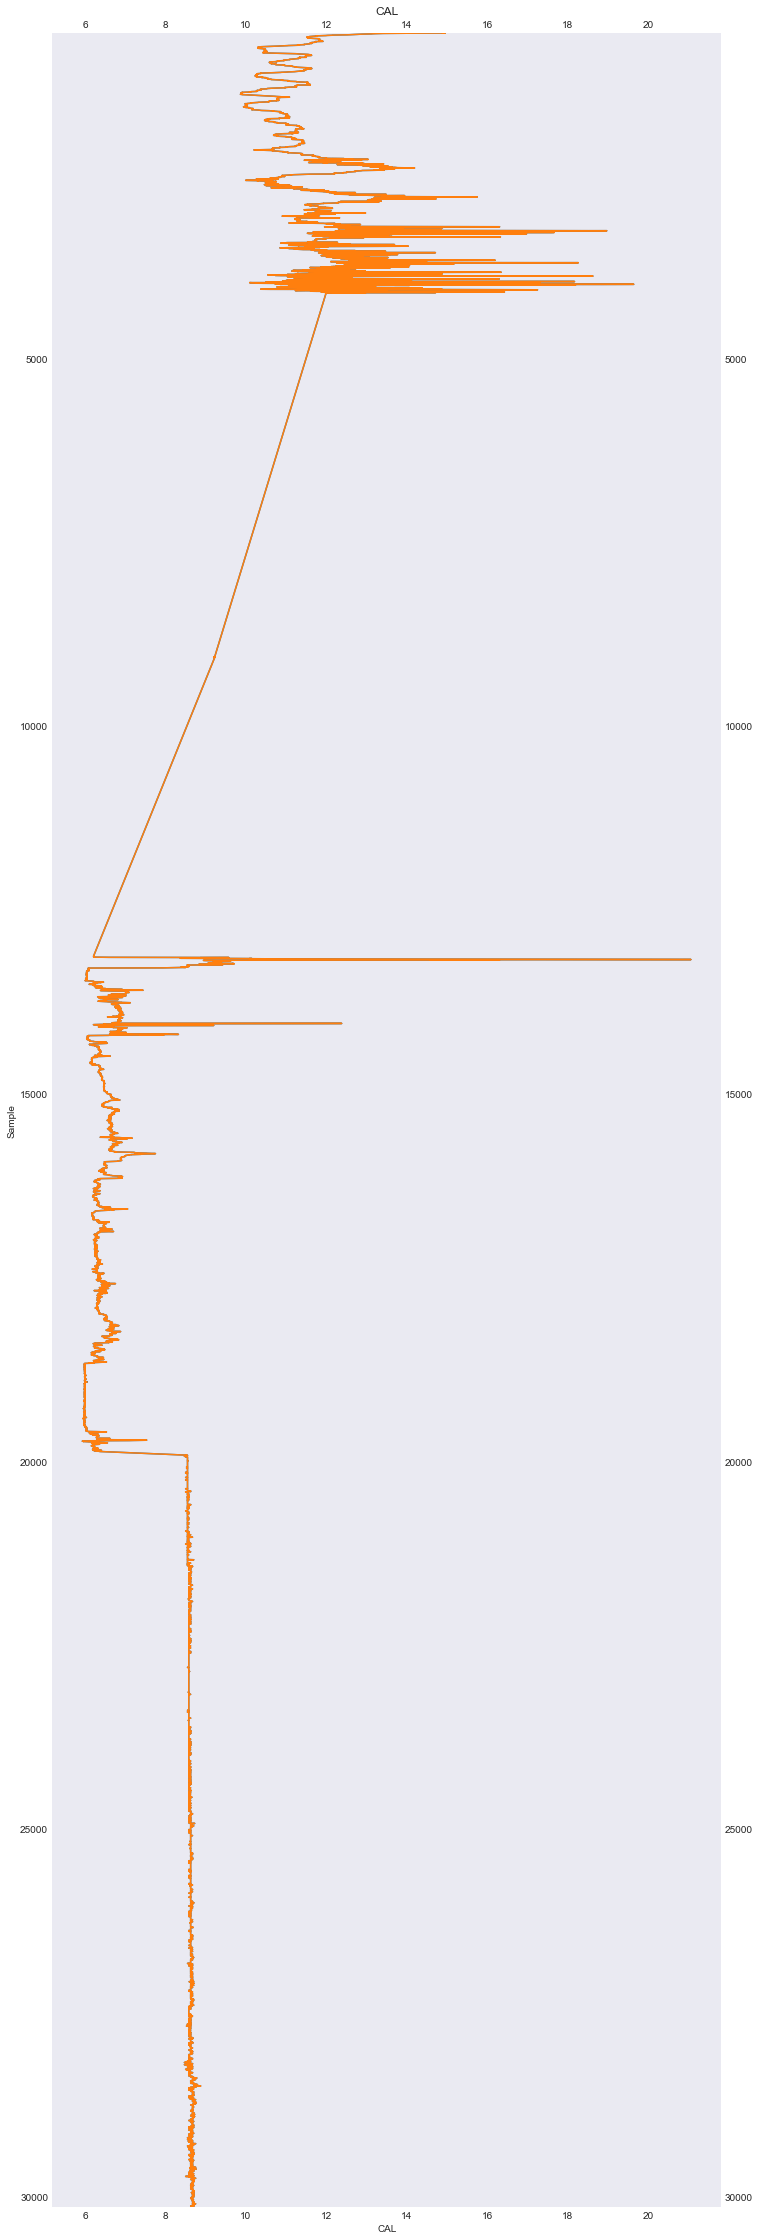

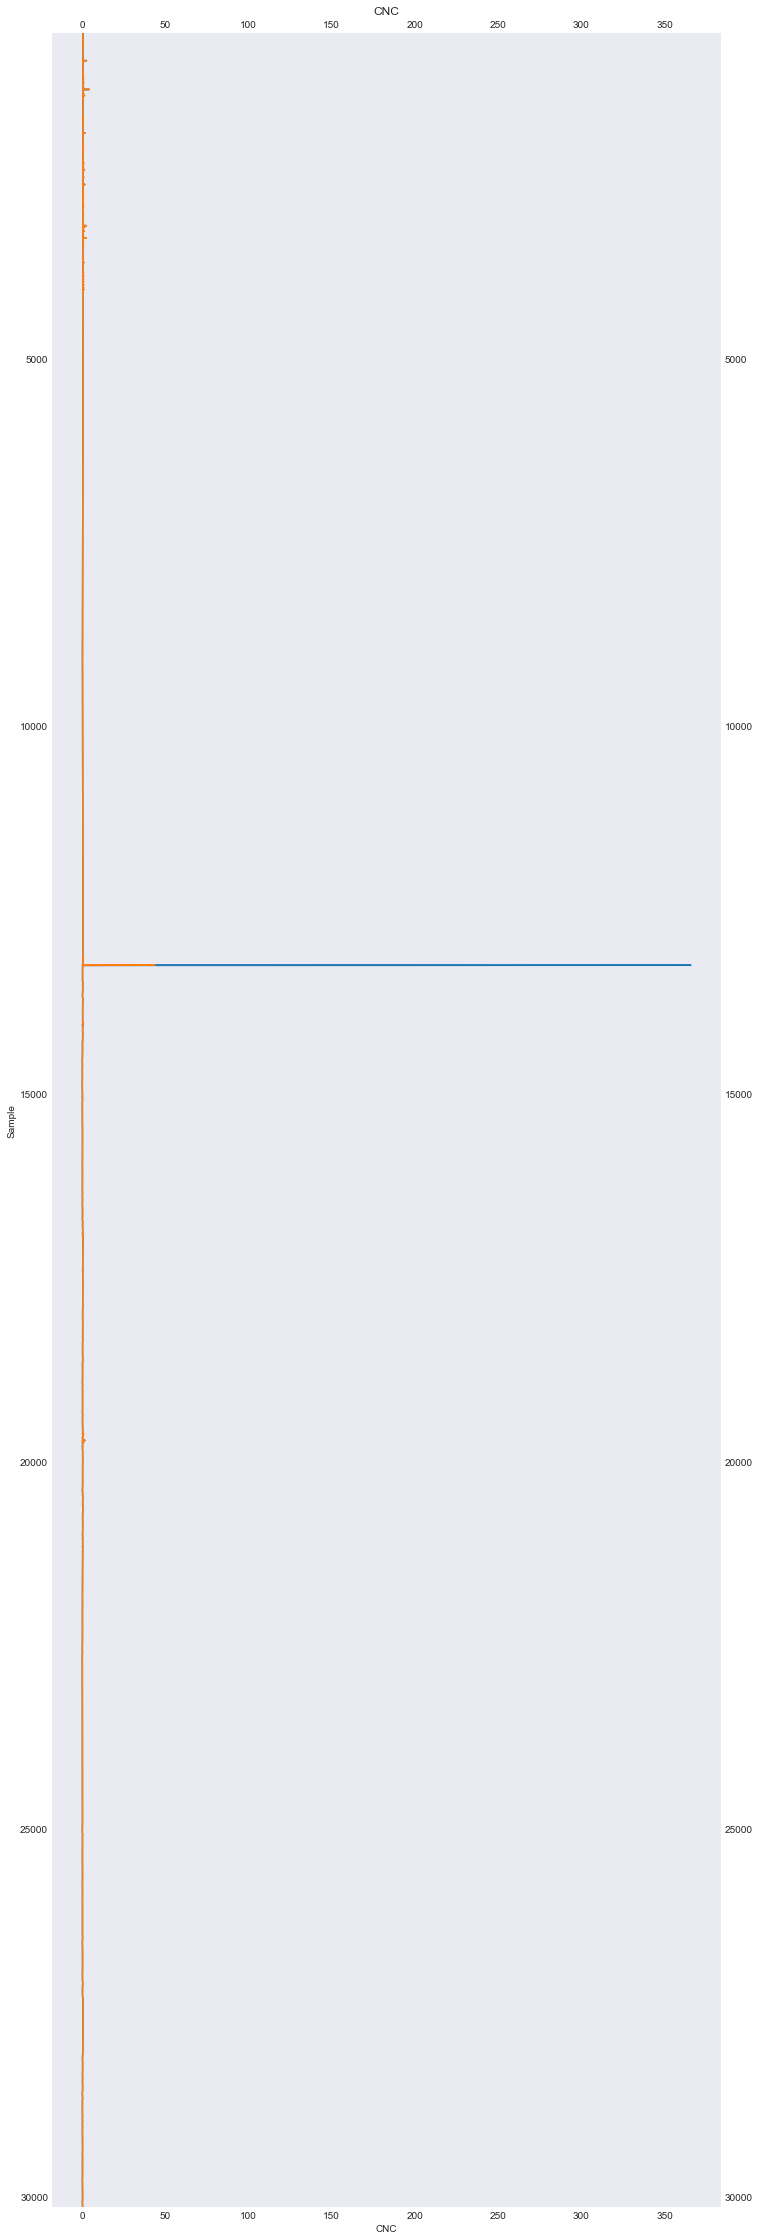

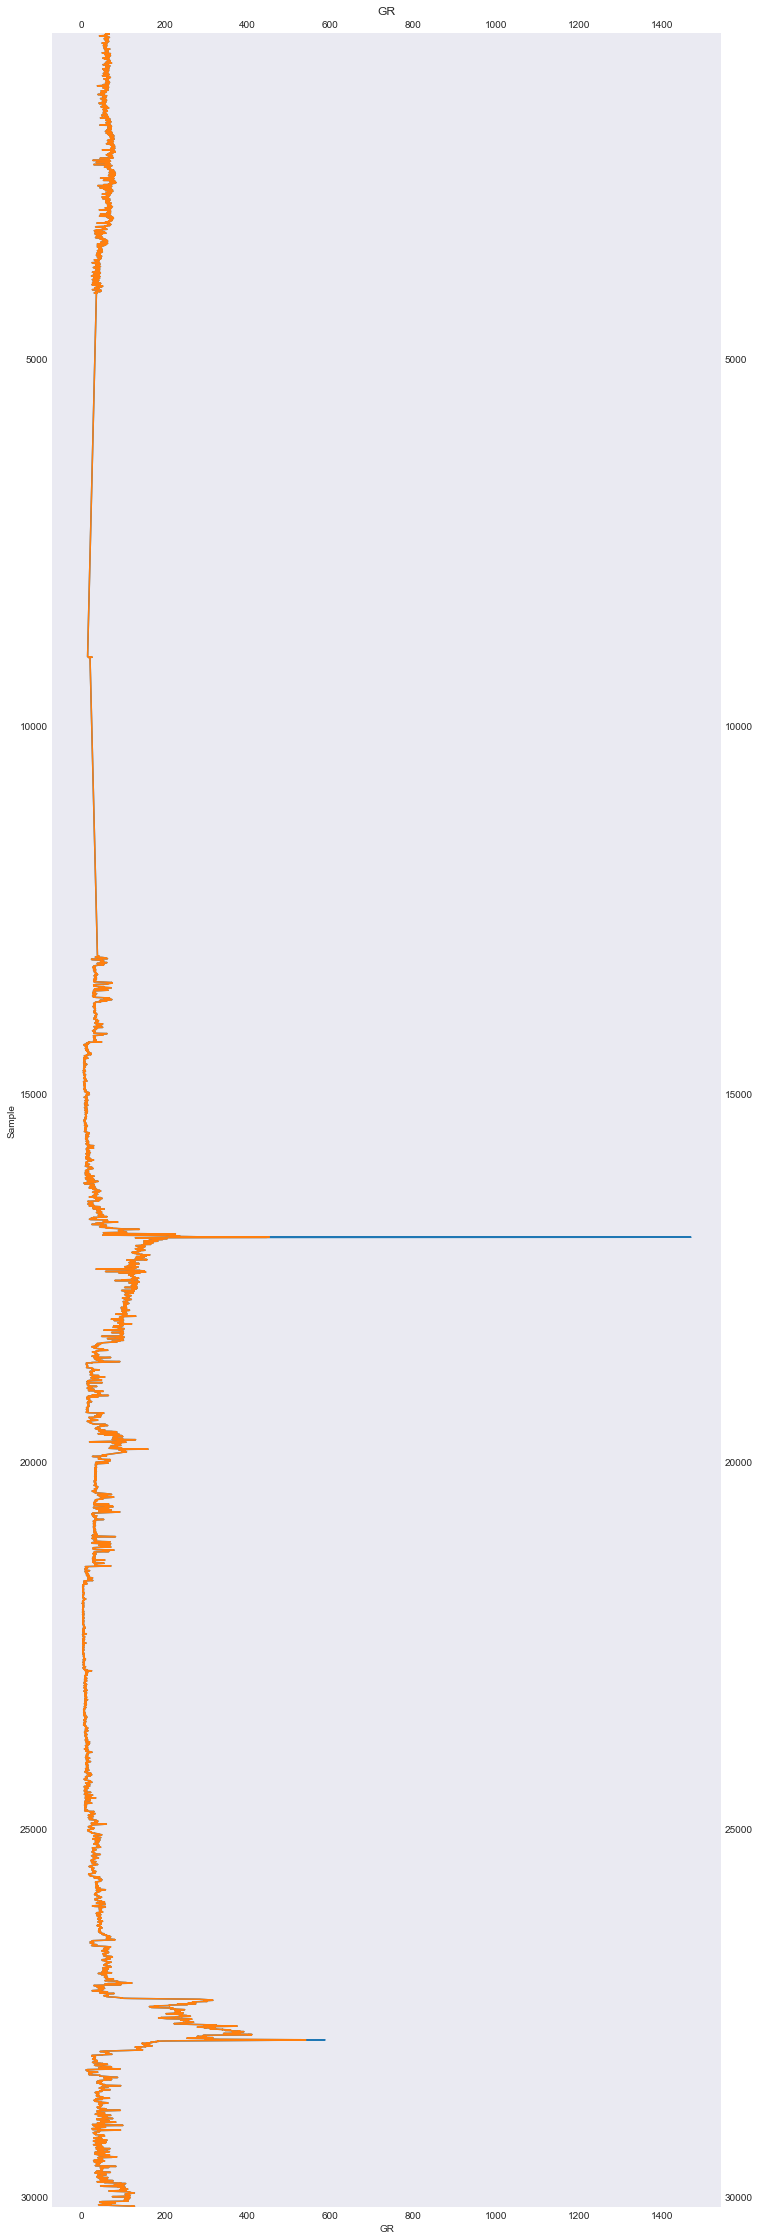

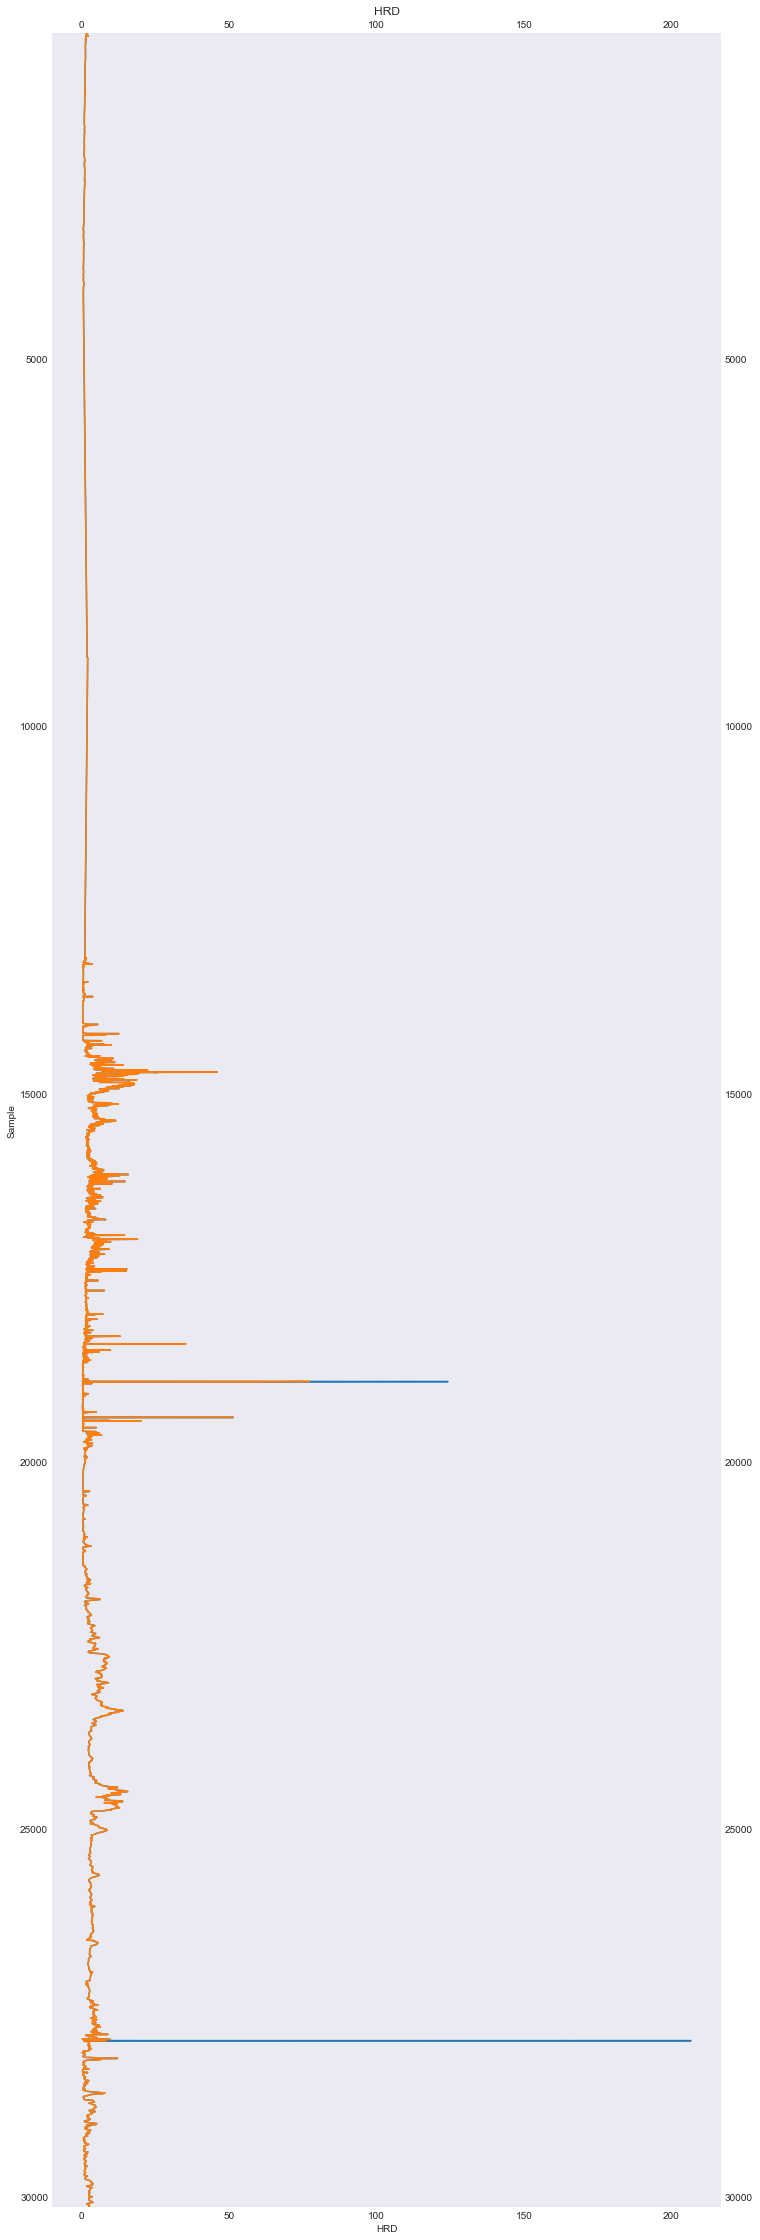

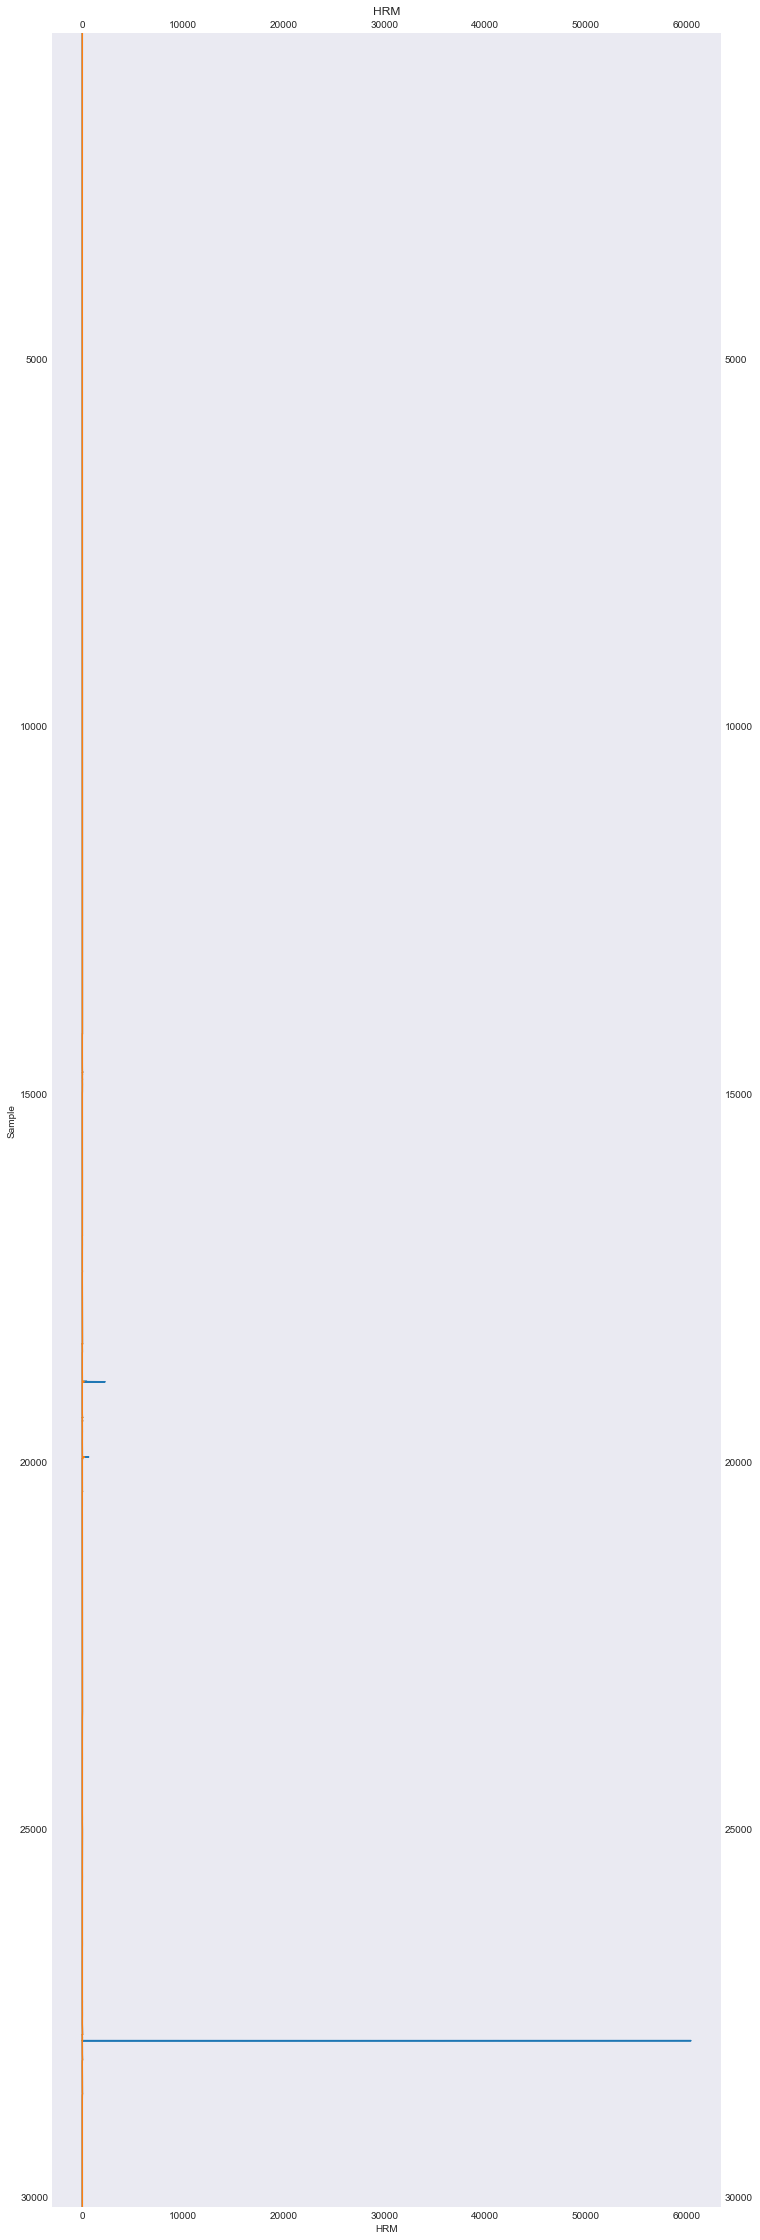

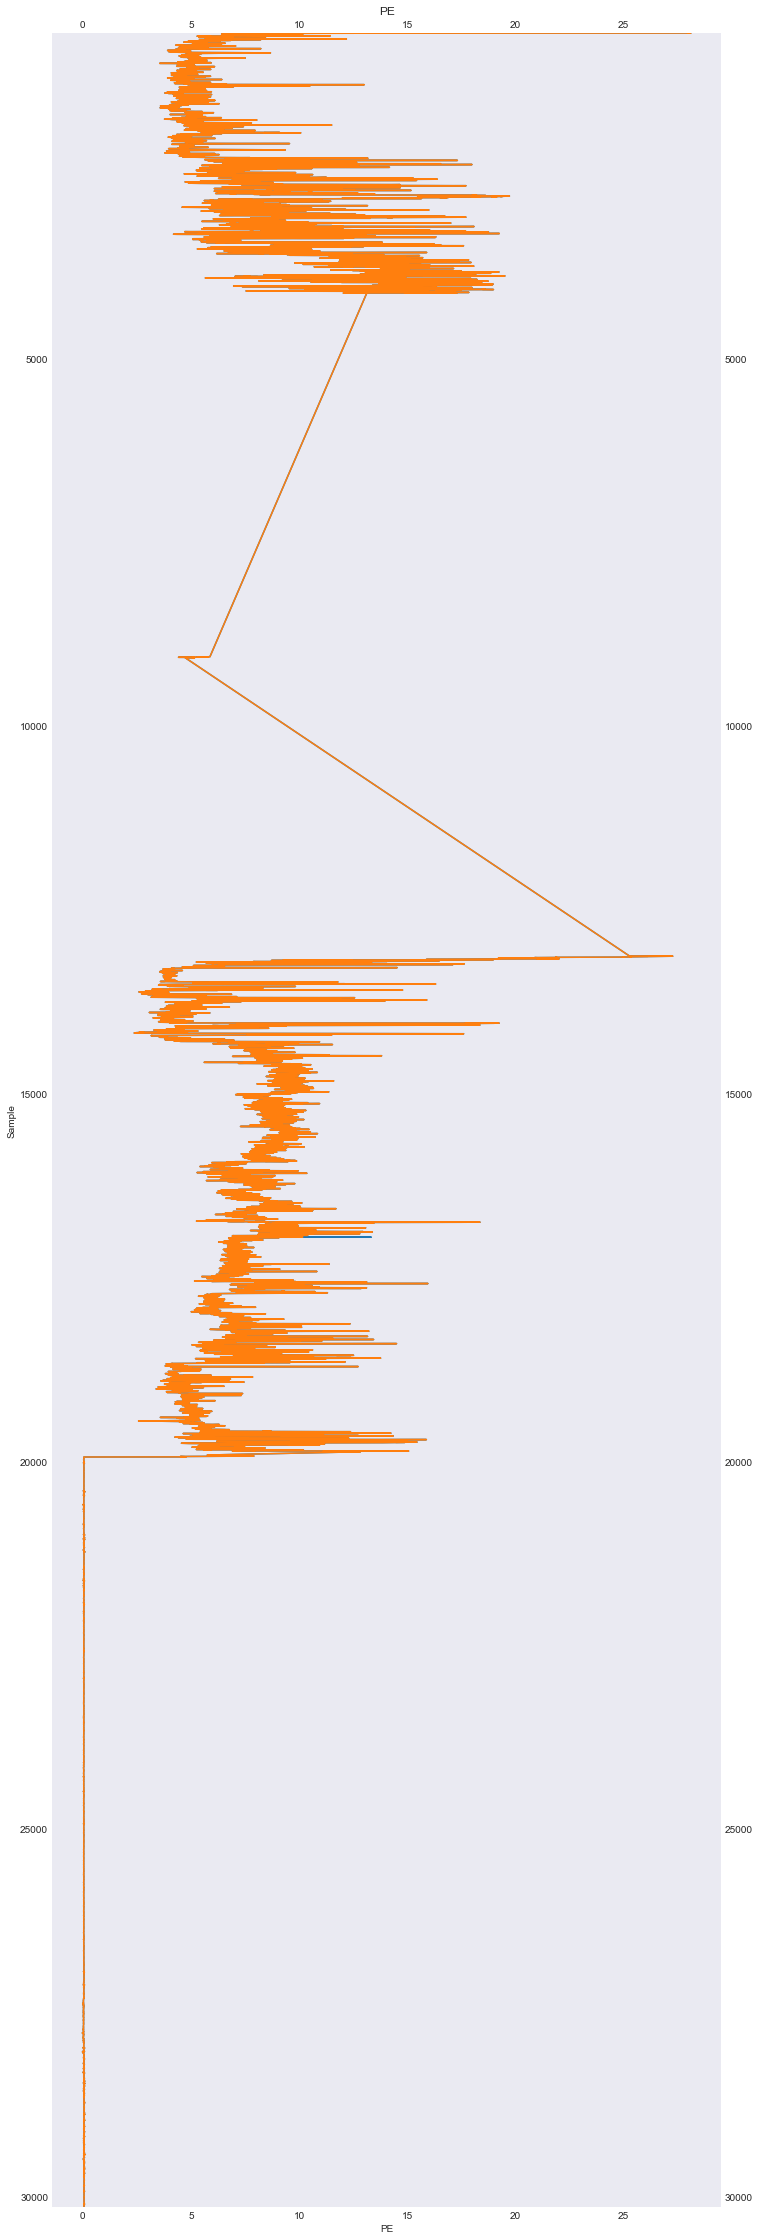

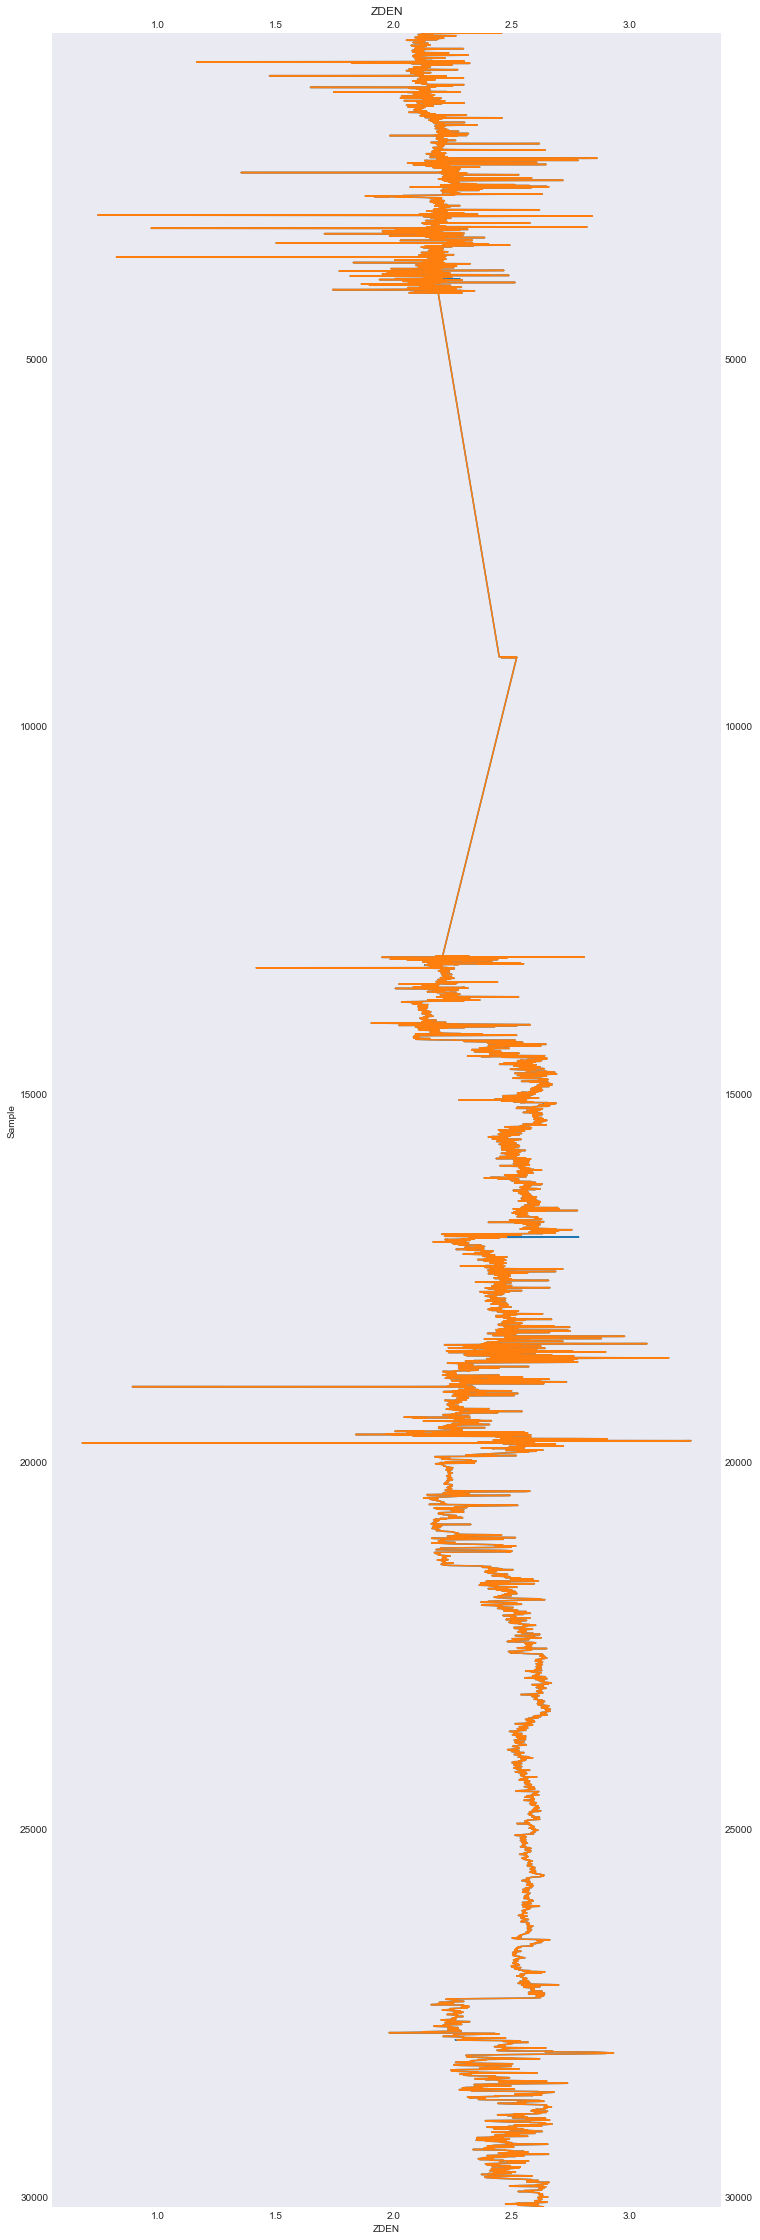

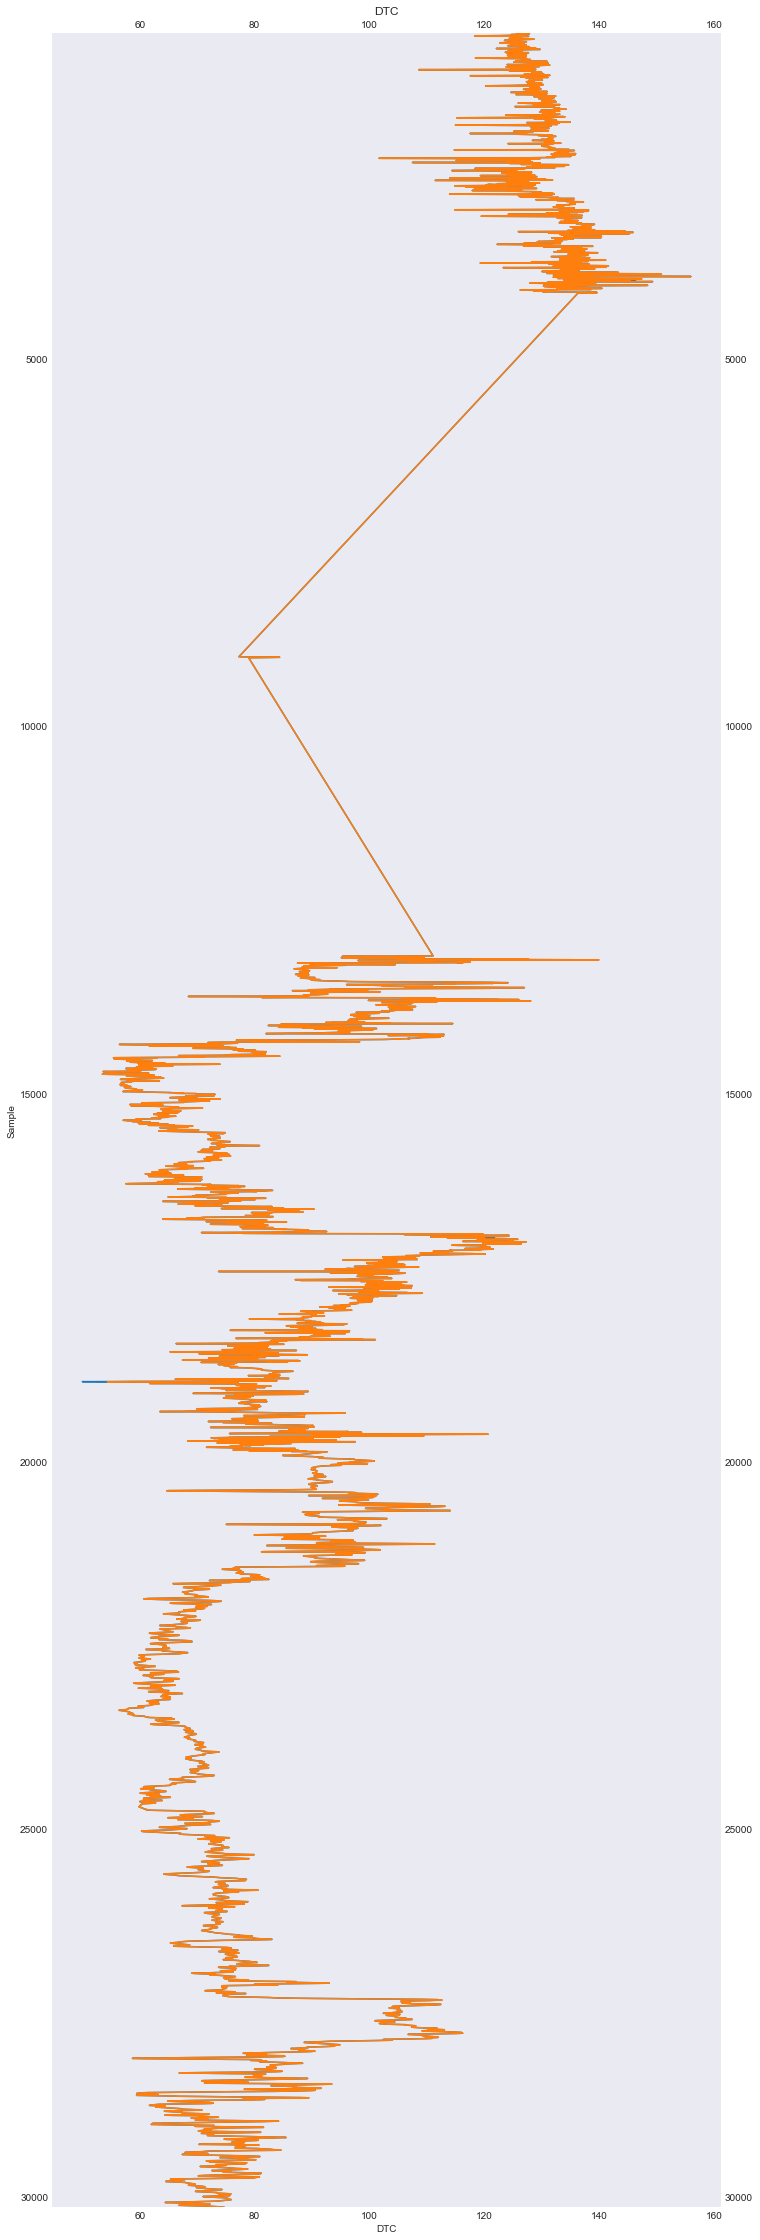

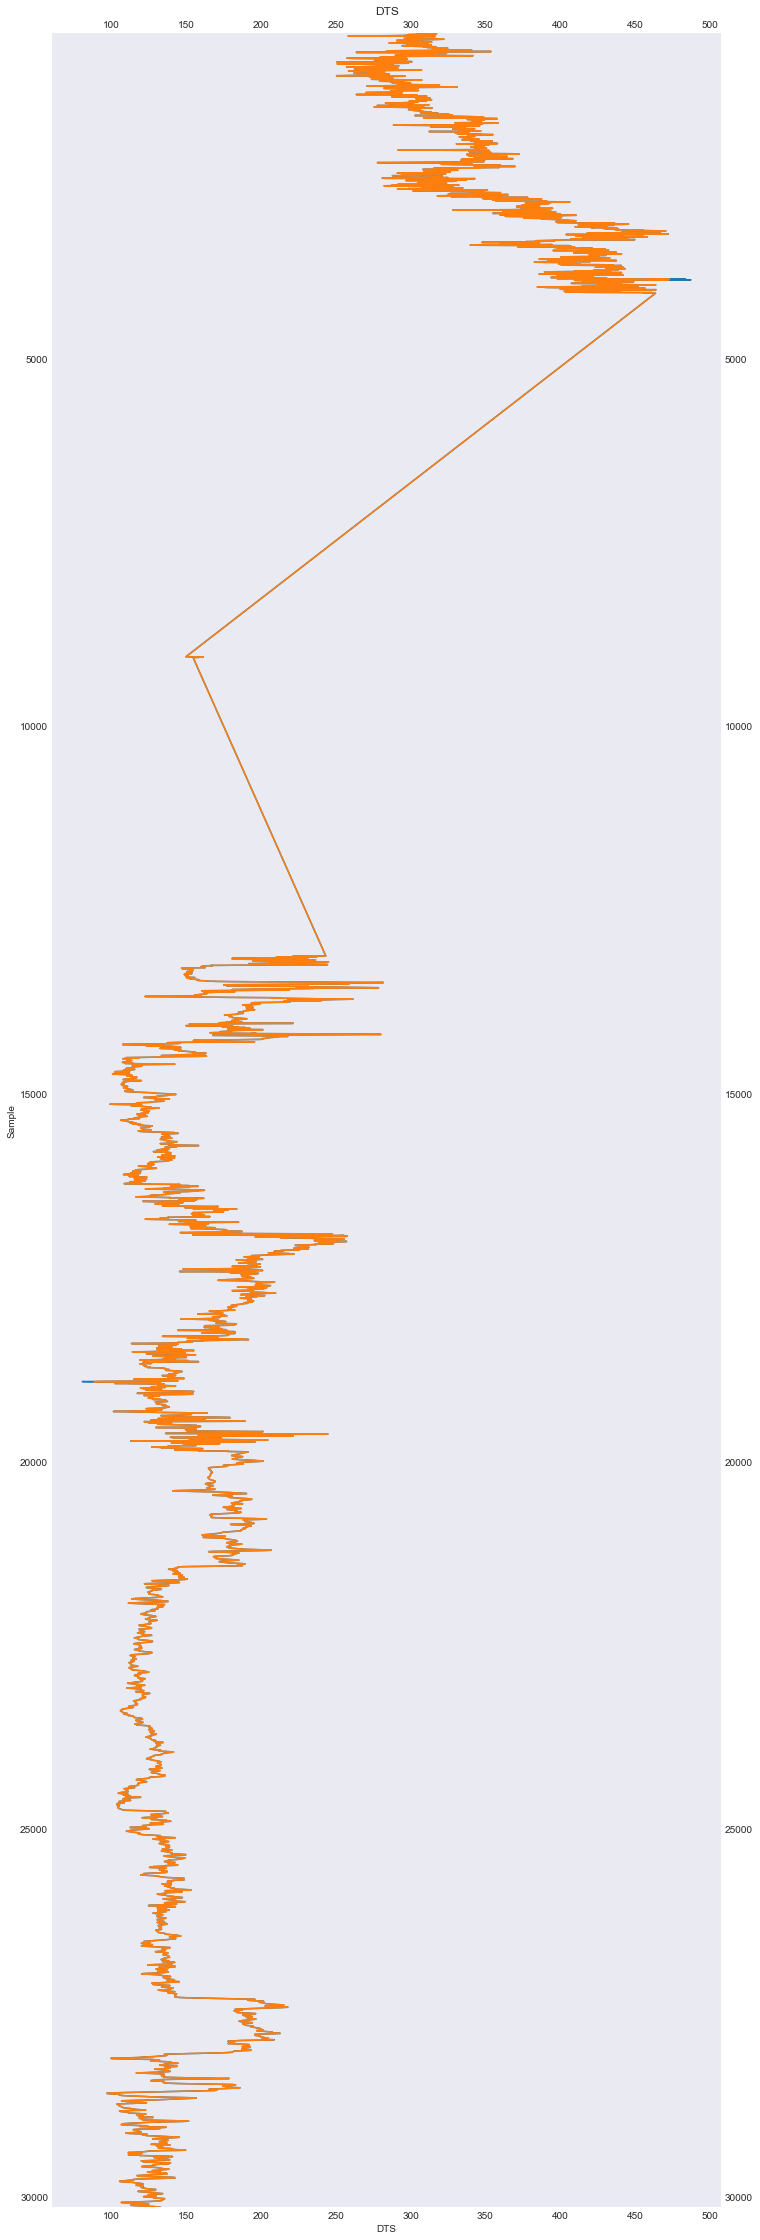

In [12]:
# Remove outliers
method = 1 # 1-OneClassSVM; 2-IsolationForest; 3-LocalOutlierFactor
outliers_fraction = 25 / 20525

# define outlier/anomaly detection methods to be compared
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma='scale')),
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction, random_state=42, behaviour="new")),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction))] # 'auto'))]


# if method == 1:
#     # clf = svm.OneClassSVM(nu=outliers_fraction, gamma=0.1).fit(df1)
#     clf = svm.OneClassSVM(nu=outliers_fraction, gamma='scale').fit(df1[['CNC']])
#     normal = clf.fit_predict(df1[['CNC']])
# elif method == 2:
#     clf = IsolationForest(contamination=outliers_fraction, random_state=42, behaviour="new")
#     normal = clf.fit_predict(df1[['CNC']])
# elif method == 3:
#     clf = LocalOutlierFactor(n_neighbors=35, contamination='auto') #=outliers_fraction)
#     normal = clf.fit_predict(df1[['CNC']])

normal = np.zeros(df1.shape[0], )

print('method = ', method, ': ', anomaly_algorithms[method][0])

clf = anomaly_algorithms[method][1].fit_predict(df1)
    
for i, item in enumerate(logs):
    plt.figure(figsize=(12.0, 40.0))
    log_plot(df1.index, df1[item])
    log_plot(df1.index[clf==1], df1[item][clf==1], item, title=item)
    
print("Number of anomalies = ", -sum(clf[clf==-1]))

# # remove anamoly
# if method in [0, 1, 2, 3]:
#     df1 = df1[clf==1]
#     print(df1.shape)

# # detect anomaly for each features
# for i, item in enumerate(logs):
#     clf = anomaly_algorithms[method][1].fit_predict(df1[[item]])
    
#     plt.figure(figsize=(12.0, 40.0))
#     log_plot(df1.index, df1[item])
#     log_plot(df1.index[clf==1], df1[item][clf==1], item, title=item)
#     # plt.xlim(0, 1.1)
#     print(item, -sum(clf[clf==-1]))
    
#     normal += clf

In [13]:
# print(normal.shape)

# # remove anamoly

# if method in [0, 1, 2, 3]:
   
#     df1 = df1[normal==df1.shape[1]]
#     print(df1.shape)

In [14]:
# # Remove outlier by measuring z-score
# z_scores = stats.zscore(df1)
# abs_z_scores = np.abs(z_scores)
# filtered_entries = (abs_z_scores < 5).all(axis=1)
# new_df = df1[filtered_entries]

# new_df.info(verbose=True)

# for i, item in enumerate(logs[:-2]):
#     plt.figure()
#     plt.plot(df1.index, df1[item])
#     plt.plot(new_df.index, new_df[item])
#     plt.title( item + ', # of nan = ' + str(df1[item].isna().sum()) )

In [15]:
# # Remove DTC >=110
# if False:
#     print(df1.shape)

#     df1= df1[df1["DTC"] < 110]

#     print(df1.shape)

In [16]:
# df1.columns.tolist()

In [17]:
# print(df1['DTC'].shape)
# plt.scatter(df1.index, df1['DTC'], s=1)
# plt.title('DTC')

In [18]:
# plt.scatter(df1.index, df1['CNC'], s=1)

In [19]:
# plt.scatter(df1.index, df1['CAL'], s=1)
# # plt.title('CAL')

In [20]:
# # check if there's any co-linearity between features
# # you may check this for all of the features and see if there's any good finding. 
# plt.scatter(df1['CAL'], df1['DTC'], s=10, alpha=0.5)

In [21]:
# # check if there's any co-linearity between features
# # you may check this for all of the features and see if there's any good finding. 
# plt.scatter(df1['DTC'], df1['DTS'], s=10, alpha=0.5)

In [22]:
# # another library from Seaborn to check the co-linearity
# sb.pairplot(df1[['ZDEN', 'DTC']])
# # sb.pairplot(df1[['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN', 'DTC', 'DTS']])

## <a>6. Build Machine Learning Models</a>

<a>Top</a>

In [23]:
# # seperate the features and targets
# df_data = np.array(df1)
# y_trainwell1 = df_data[:,-2:]
# x_trainwell1 = df_data[:,:-2]

# # standize the matrix for training data
# scaler = StandardScaler()
# x_trainwell1 = scaler.fit_transform(x_trainwell1)

In [24]:
# print(y_trainwell1[:5][:])

In [25]:
# np.shape(y_trainwell1)

In [26]:
# # train test split
# # please remember to use random_state for all randomization steps, this will ensure we get the same results 
# # as yours during the validation phase. 
# X_train, X_test, y_train, y_test = train_test_split(x_trainwell1, y_trainwell1, test_size=0.2, random_state=100)


In [27]:
# def grid_search(clf, param_grid, X_train=X_train, y_train=y_train):
#     """
#     Fits a classifier to its training data and prints its ROC AUC score.
    
#     INPUT:
#     - clf (classifier): classifier to fit
#     - param_grid (dict): classifier parameters used with GridSearchCV
#     - X_train (DataFrame): training input
#     - y_train (DataFrame): training output
            
#     OUTPUT:
#     - classifier: input classifier fitted to the training data
#     """
#     # cv uses StratifiedKFold
#     # scoring r2 as parameter
#     grid = GridSearchCV(estimator=clf, 
#                         param_grid=param_grid, 
#                         scoring='r2', 
#                         cv=5)
#     grid.fit(X_train, y_train)
#     print(grid.best_score_)
#     print(grid.cv_results_)
#     print(grid.best_estimator_)
#     print(grid.best_params_)
    
#     return grid.best_estimator_

In [28]:
def result_plot(y_predict, y_real):
    # check the accuracy of predicted data and plot the result
    print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_real, y_predict))))
    plt.subplots(nrows=2, ncols=2, figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(y_real[:, 0])
    plt.plot(y_predict[:, 0])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTC')
    plt.title('DTC Prediction Comparison')

    plt.subplot(2, 2, 2)
    plt.plot(y_real[:, 1])
    plt.plot(y_predict[:, 1])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTS')
    plt.title('DTS Prediction Comparison')
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_real[:, 0], y_predict[:, 0])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTC Prediction Comparison')
    
    plt.subplot(2, 2, 4)
    plt.scatter(y_real[:, 1], y_predict[:, 1])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTS Prediction Comparison')

    plt.show()

In [29]:
# # Linear regression model as the baseline
# LR = LinearRegression()
# LR_best = grid_search(LR, {})
# LR_predict = LR_best.predict(x_trainwell1)
# result_plot(LR_predict, y_trainwell1)

In [30]:
# # Add ridge regularization, and see if there's any improvement
# ridge = RidgeCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1], )
# ridge.fit(X_train, y_train)
# print('Accuracy Score is:', '{:.5f}'.format(ridge.score(X_train, y_train)))
# result_plot(ridge.predict(x_trainwell1), y_trainwell1)

In [31]:
# # Random forest model
# parameters = {} # {'n_estimators':[150, 300]}
# RF = RandomForestRegressor(n_estimators=140, random_state=100)
# RF_best = grid_search(RF, parameters)
# result_plot(RF_best.predict(x_trainwell1), y_trainwell1)
# RF_best.get_params()

In [32]:
# # Epsilon-Support Vector Regression
# parameters = {}
# SVR = svm.SVR(kernel='rbf', degree=5, gamma='scale')
# SVR.fit(x_trainwell1, y_trainwell1[:, 0])
# SVR2 = svm.SVR(kernel='rbf', degree=5, gamma='scale')
# SVR2.fit(x_trainwell1, y_trainwell1[:, 1])

# pred1 = SVR.predict(x_trainwell1)
# pred2 = SVR2.predict(x_trainwell1)

In [33]:
# y_pred = np.column_stack((pred1, pred2))
# print(pred1.shape)
# print(y_pred.shape)
# print(y_trainwell1.shape)

# result_plot(y_pred, y_trainwell1)

# # check the result on test dataset only
# result_plot(np.column_stack((SVR.predict(X_test), SVR2.predict(X_test))), y_test)

In [85]:
# ANN
test_dataset = df1.sample(frac=0.1, random_state=100)
train_dataset = df1.drop(test_dataset.index)

train_stats = train_dataset.describe()
train_stats = train_stats.iloc[:,:-2].transpose()
# print(train_stats)

train_labels = np.array(train_dataset.iloc[:,-2:])
test_labels = np.array(test_dataset.iloc[:,-2:])

N_TRAIN = len(train_dataset.index)
EPOCHS = 800
BATCH_SIZE = 512
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = np.array(norm(train_dataset.iloc[:,:-2])).reshape(-1, 7, 1)
normed_test_data = np.array(norm(test_dataset.iloc[:,:-2])).reshape(-1, 7, 1)

# def build_model():
#   model = keras.Sequential([
#     layers.Dense(128, activation='relu', input_shape=[len(normed_train_data.keys())]),
#     layers.Dropout(0.3, noise_shape=None, seed=None)
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.2, noise_shape=None, seed=None)
#     layers.Dense(64, activation='relu'),
# #     layers.Dense(16, activation='relu'),
# #     layers.Dense(8,  activation='relu'),
#     layers.Dense(2,  activation='linear')
#  ])

def build_model():
    model = keras.Sequential([
        # layers.Bidirectional(layers.LSTM(10, return_sequences=True), input_shape=[len(normed_train_data.keys()), 7]),
        # layers.Bidirectional(layers.LSTM(10)),
        layers.Bidirectional(layers.LSTM(64,  return_sequences=True)),
        layers.Bidirectional(layers.LSTM(32)),
        layers.Dense(64, activation='relu'),
        # layers.Dropout(0.5),
        layers.Dense(2)
    ])

    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.002,
        decay_steps=STEPS_PER_EPOCH*200,
        decay_rate=1,
        staircase=False)
    
    # optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
    # optimizer = tf.keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
    # optimizer = tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
    # optimizer = tf.keras.optimizers.RMSprop(0.001)
    optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_2=0.999, amsgrad=True)

    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mse'])
    return model


model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

# model.summary()

# print(normed_train_data[:10], )

# example_batch = normed_train_data[:10]
# example_result = model.predict(example_batch)
# example_result

history = model.fit(
  normed_train_data, train_labels,
  batch_size=BATCH_SIZE, epochs=EPOCHS, 
  validation_data=(np.array(normed_test_data), np.array(test_labels)), 
  # validation_split = 0.01, 
  verbose=1,
  callbacks=[early_stop, tfdocs.modeling.EpochDots()])

Train on 18473 samples, validate on 2052 samples
Epoch 1/800
17920/18473 [============================>.] - ETA: 0s - loss: 22488.3820 - mse: 22488.3828
Epoch: 0, loss:22361.2023,  mse:22361.2031,  val_loss:19281.2954,  val_mse:19281.2949,  
18473/18473 [==============================] - 7s 383us/sample - loss: 22361.2023 - mse: 22361.2031 - val_loss: 19281.2954 - val_mse: 19281.2949
Epoch 2/800
18473/18473 [==============================] - 1s 77us/sample - loss: 12540.0015 - mse: 12540.0010 - val_loss: 8429.7516 - val_mse: 8429.7500
Epoch 3/800
18473/18473 [==============================] - 1s 78us/sample - loss: 5151.8241 - mse: 5151.8247 - val_loss: 4652.7222 - val_mse: 4652.7222
Epoch 4/800
18473/18473 [==============================] - 1s 77us/sample - loss: 3852.8650 - mse: 3852.8645 - val_loss: 4369.2209 - val_mse: 4369.2207
Epoch 5/800
18473/18473 [==============================] - 1s 79us/sample - loss: 3806.1740 - mse: 3806.1743 - val_loss: 4368.9412 - val_mse: 4368.9414
Epo

18473/18473 [==============================] - 1s 79us/sample - loss: 151.8526 - mse: 151.8525 - val_loss: 156.9871 - val_mse: 156.9871
Epoch 55/800
18473/18473 [==============================] - 1s 79us/sample - loss: 151.3385 - mse: 151.3385 - val_loss: 145.1879 - val_mse: 145.1879
Epoch 56/800
18473/18473 [==============================] - 1s 76us/sample - loss: 147.6495 - mse: 147.6495 - val_loss: 144.7971 - val_mse: 144.7971
Epoch 57/800
18473/18473 [==============================] - 1s 80us/sample - loss: 138.3934 - mse: 138.3933 - val_loss: 153.8172 - val_mse: 153.8172
Epoch 58/800
18473/18473 [==============================] - 1s 79us/sample - loss: 140.6671 - mse: 140.6670 - val_loss: 133.0371 - val_mse: 133.0371
Epoch 59/800
18473/18473 [==============================] - 1s 76us/sample - loss: 131.8267 - mse: 131.8267 - val_loss: 134.6778 - val_mse: 134.6778
Epoch 60/800
18473/18473 [==============================] - 1s 79us/sample - loss: 128.6857 - mse: 128.6857 - val_loss:

18473/18473 [==============================] - 1s 75us/sample - loss: 87.6238 - mse: 87.6238 - val_loss: 84.1603 - val_mse: 84.1603
Epoch 109/800
18473/18473 [==============================] - 1s 77us/sample - loss: 84.4786 - mse: 84.4786 - val_loss: 82.3727 - val_mse: 82.3727
Epoch 110/800
18473/18473 [==============================] - 1s 76us/sample - loss: 83.4525 - mse: 83.4525 - val_loss: 85.4208 - val_mse: 85.4208
Epoch 111/800
18473/18473 [==============================] - 1s 80us/sample - loss: 86.0129 - mse: 86.0129 - val_loss: 84.9223 - val_mse: 84.9223
Epoch 112/800
18473/18473 [==============================] - 1s 76us/sample - loss: 85.5037 - mse: 85.5037 - val_loss: 81.9158 - val_mse: 81.9158
Epoch 113/800
18473/18473 [==============================] - 1s 74us/sample - loss: 84.8277 - mse: 84.8277 - val_loss: 81.8876 - val_mse: 81.8876
Epoch 114/800
18473/18473 [==============================] - 1s 78us/sample - loss: 83.7447 - mse: 83.7447 - val_loss: 82.0616 - val_mse: 

18473/18473 [==============================] - 2s 81us/sample - loss: 75.2529 - mse: 75.2529 - val_loss: 72.6952 - val_mse: 72.6952
Epoch 165/800
18473/18473 [==============================] - 1s 78us/sample - loss: 71.9534 - mse: 71.9534 - val_loss: 76.4410 - val_mse: 76.4410
Epoch 166/800
18473/18473 [==============================] - 1s 77us/sample - loss: 71.5434 - mse: 71.5434 - val_loss: 76.7523 - val_mse: 76.7523
Epoch 167/800
18473/18473 [==============================] - 2s 82us/sample - loss: 71.7769 - mse: 71.7769 - val_loss: 72.8940 - val_mse: 72.8940
Epoch 168/800
18473/18473 [==============================] - 1s 78us/sample - loss: 72.3083 - mse: 72.3083 - val_loss: 73.9303 - val_mse: 73.9303
Epoch 169/800
18473/18473 [==============================] - 1s 78us/sample - loss: 71.8301 - mse: 71.8301 - val_loss: 76.2679 - val_mse: 76.2679
Epoch 170/800
18473/18473 [==============================] - 1s 77us/sample - loss: 73.0769 - mse: 73.0769 - val_loss: 82.0989 - val_mse: 

18473/18473 [==============================] - 1s 75us/sample - loss: 67.9091 - mse: 67.9091 - val_loss: 68.8133 - val_mse: 68.8134
Epoch 220/800
18473/18473 [==============================] - 1s 75us/sample - loss: 65.9224 - mse: 65.9224 - val_loss: 74.0211 - val_mse: 74.0211
Epoch 221/800
18473/18473 [==============================] - 1s 80us/sample - loss: 67.1156 - mse: 67.1156 - val_loss: 67.5824 - val_mse: 67.5824
Epoch 222/800
18473/18473 [==============================] - 1s 76us/sample - loss: 65.4243 - mse: 65.4243 - val_loss: 69.8683 - val_mse: 69.8683
Epoch 223/800
18473/18473 [==============================] - 1s 79us/sample - loss: 66.0645 - mse: 66.0645 - val_loss: 69.1916 - val_mse: 69.1916
Epoch 224/800
18473/18473 [==============================] - 1s 77us/sample - loss: 65.5698 - mse: 65.5698 - val_loss: 69.4448 - val_mse: 69.4448
Epoch 225/800
18473/18473 [==============================] - 1s 79us/sample - loss: 66.3860 - mse: 66.3860 - val_loss: 70.2795 - val_mse: 

Epoch 275/800
18473/18473 [==============================] - 1s 79us/sample - loss: 60.8646 - mse: 60.8646 - val_loss: 68.6348 - val_mse: 68.6348
Epoch 276/800
18473/18473 [==============================] - 1s 80us/sample - loss: 63.0840 - mse: 63.0840 - val_loss: 66.6335 - val_mse: 66.6335
Epoch 277/800
18473/18473 [==============================] - 1s 78us/sample - loss: 61.6778 - mse: 61.6778 - val_loss: 70.1715 - val_mse: 70.1715
Epoch 278/800
18473/18473 [==============================] - 2s 82us/sample - loss: 62.6048 - mse: 62.6048 - val_loss: 64.4440 - val_mse: 64.4440
Epoch 279/800
18473/18473 [==============================] - 2s 82us/sample - loss: 61.8862 - mse: 61.8862 - val_loss: 66.4864 - val_mse: 66.4864
Epoch 280/800
18473/18473 [==============================] - 1s 80us/sample - loss: 62.4700 - mse: 62.4700 - val_loss: 67.1336 - val_mse: 67.1336
Epoch 281/800
18473/18473 [==============================] - 2s 82us/sample - loss: 62.5341 - mse: 62.5341 - val_loss: 64.49

Epoch 330/800
18473/18473 [==============================] - 1s 79us/sample - loss: 59.6792 - mse: 59.6792 - val_loss: 62.9828 - val_mse: 62.9828
Epoch 331/800
18473/18473 [==============================] - 1s 78us/sample - loss: 59.3157 - mse: 59.3157 - val_loss: 62.7238 - val_mse: 62.7238
Epoch 332/800
18473/18473 [==============================] - 2s 81us/sample - loss: 58.9835 - mse: 58.9835 - val_loss: 62.3255 - val_mse: 62.3255
Epoch 333/800
18473/18473 [==============================] - 1s 78us/sample - loss: 59.2220 - mse: 59.2220 - val_loss: 62.8905 - val_mse: 62.8905
Epoch 334/800
18473/18473 [==============================] - 1s 80us/sample - loss: 59.0314 - mse: 59.0314 - val_loss: 64.6576 - val_mse: 64.6576
Epoch 335/800
18473/18473 [==============================] - 1s 77us/sample - loss: 59.7856 - mse: 59.7856 - val_loss: 64.7609 - val_mse: 64.7609
Epoch 336/800
18473/18473 [==============================] - 1s 77us/sample - loss: 59.9170 - mse: 59.9170 - val_loss: 64.12

18473/18473 [==============================] - 1s 79us/sample - loss: 57.9735 - mse: 57.9735 - val_loss: 62.1510 - val_mse: 62.1510
Epoch 387/800
18473/18473 [==============================] - 1s 79us/sample - loss: 57.8071 - mse: 57.8071 - val_loss: 64.5123 - val_mse: 64.5123
Epoch 388/800
18473/18473 [==============================] - 1s 80us/sample - loss: 59.4396 - mse: 59.4396 - val_loss: 61.3918 - val_mse: 61.3918
Epoch 389/800
18473/18473 [==============================] - 1s 80us/sample - loss: 57.6602 - mse: 57.6602 - val_loss: 61.2916 - val_mse: 61.2916
Epoch 390/800
18473/18473 [==============================] - 1s 77us/sample - loss: 57.3470 - mse: 57.3470 - val_loss: 61.9595 - val_mse: 61.9595
Epoch 391/800
18473/18473 [==============================] - 1s 79us/sample - loss: 57.7161 - mse: 57.7161 - val_loss: 62.0195 - val_mse: 62.0195
Epoch 392/800
18473/18473 [==============================] - 1s 78us/sample - loss: 57.5688 - mse: 57.5688 - val_loss: 62.7550 - val_mse: 

18473/18473 [==============================] - 1s 78us/sample - loss: 56.7626 - mse: 56.7626 - val_loss: 59.6959 - val_mse: 59.6959
Epoch 442/800
18473/18473 [==============================] - 1s 78us/sample - loss: 56.2712 - mse: 56.2712 - val_loss: 60.8839 - val_mse: 60.8839
Epoch 443/800
18473/18473 [==============================] - 1s 78us/sample - loss: 56.3723 - mse: 56.3723 - val_loss: 61.0160 - val_mse: 61.0160
Epoch 444/800
18473/18473 [==============================] - 1s 79us/sample - loss: 56.6888 - mse: 56.6888 - val_loss: 62.9696 - val_mse: 62.9696
Epoch 445/800
18473/18473 [==============================] - 1s 80us/sample - loss: 56.4826 - mse: 56.4826 - val_loss: 60.4818 - val_mse: 60.4818
Epoch 446/800
18473/18473 [==============================] - 2s 82us/sample - loss: 56.9862 - mse: 56.9862 - val_loss: 61.6815 - val_mse: 61.6815
Epoch 447/800
18473/18473 [==============================] - 2s 82us/sample - loss: 56.7758 - mse: 56.7758 - val_loss: 61.0659 - val_mse: 

18473/18473 [==============================] - 1s 78us/sample - loss: 56.9153 - mse: 56.9153 - val_loss: 59.7926 - val_mse: 59.7926
Epoch 498/800
18473/18473 [==============================] - 1s 79us/sample - loss: 55.5891 - mse: 55.5891 - val_loss: 59.5284 - val_mse: 59.5285
Epoch 499/800
18473/18473 [==============================] - 1s 77us/sample - loss: 55.4756 - mse: 55.4756 - val_loss: 59.4376 - val_mse: 59.4376
Epoch 500/800
18473/18473 [==============================] - 1s 79us/sample - loss: 55.7872 - mse: 55.7872 - val_loss: 61.2758 - val_mse: 61.2758
Epoch 501/800
17920/18473 [============================>.] - ETA: 0s - loss: 55.0156 - mse: 55.0156
Epoch: 500, loss:55.1221,  mse:55.1221,  val_loss:59.8440,  val_mse:59.8440,  
18473/18473 [==============================] - 1s 81us/sample - loss: 55.1221 - mse: 55.1221 - val_loss: 59.8440 - val_mse: 59.8440
Epoch 502/800
18473/18473 [==============================] - 1s 79us/sample - loss: 55.6592 - mse: 55.6592 - val_loss: 

18473/18473 [==============================] - 1s 81us/sample - loss: 54.9019 - mse: 54.9019 - val_loss: 62.4367 - val_mse: 62.4367
Epoch 553/800
18473/18473 [==============================] - 1s 78us/sample - loss: 56.7105 - mse: 56.7105 - val_loss: 59.3077 - val_mse: 59.3077
Epoch 554/800
18473/18473 [==============================] - 1s 79us/sample - loss: 55.0678 - mse: 55.0678 - val_loss: 59.7214 - val_mse: 59.7214
Epoch 555/800
18473/18473 [==============================] - 1s 77us/sample - loss: 54.9092 - mse: 54.9092 - val_loss: 60.5006 - val_mse: 60.5006
Epoch 556/800
18473/18473 [==============================] - 1s 79us/sample - loss: 54.5749 - mse: 54.5749 - val_loss: 59.3891 - val_mse: 59.3891
Epoch 557/800
18473/18473 [==============================] - 1s 80us/sample - loss: 54.6747 - mse: 54.6746 - val_loss: 60.6393 - val_mse: 60.6393
Epoch 558/800
18473/18473 [==============================] - ETA: 0s - loss: 55.0021 - mse: 55.0021 - 1s 79us/sample - loss: 54.6051 - mse

Epoch 607/800
18473/18473 [==============================] - 1s 79us/sample - loss: 53.9333 - mse: 53.9333 - val_loss: 59.0666 - val_mse: 59.0666
Epoch 608/800
18473/18473 [==============================] - 1s 79us/sample - loss: 53.6367 - mse: 53.6367 - val_loss: 59.1721 - val_mse: 59.1721
Epoch 609/800
18473/18473 [==============================] - 1s 81us/sample - loss: 53.5085 - mse: 53.5085 - val_loss: 58.8771 - val_mse: 58.8771
Epoch 610/800
18473/18473 [==============================] - 1s 75us/sample - loss: 53.7560 - mse: 53.7560 - val_loss: 60.9729 - val_mse: 60.9729
Epoch 611/800
18473/18473 [==============================] - 1s 76us/sample - loss: 54.0904 - mse: 54.0904 - val_loss: 59.8116 - val_mse: 59.8116
Epoch 612/800
18473/18473 [==============================] - 1s 79us/sample - loss: 54.0960 - mse: 54.0960 - val_loss: 59.8646 - val_mse: 59.8646
Epoch 613/800
18473/18473 [==============================] - 1s 77us/sample - loss: 54.2111 - mse: 54.2111 - val_loss: 59.25

18473/18473 [==============================] - 1s 77us/sample - loss: 53.5085 - mse: 53.5085 - val_loss: 59.1093 - val_mse: 59.1092
Epoch 664/800
18473/18473 [==============================] - 2s 89us/sample - loss: 53.6834 - mse: 53.6834 - val_loss: 58.3337 - val_mse: 58.3337
Epoch 665/800
18473/18473 [==============================] - 2s 81us/sample - loss: 53.1347 - mse: 53.1347 - val_loss: 58.9284 - val_mse: 58.9284
Epoch 666/800
18473/18473 [==============================] - 1s 81us/sample - loss: 53.0923 - mse: 53.0923 - val_loss: 61.2418 - val_mse: 61.2418
Epoch 667/800
18473/18473 [==============================] - 1s 80us/sample - loss: 53.7773 - mse: 53.7773 - val_loss: 57.9072 - val_mse: 57.9072
Epoch 668/800
18473/18473 [==============================] - 2s 82us/sample - loss: 54.0502 - mse: 54.0502 - val_loss: 58.6707 - val_mse: 58.6707
Epoch 669/800
18473/18473 [==============================] - 2s 84us/sample - loss: 53.7536 - mse: 53.7536 - val_loss: 58.7186 - val_mse: 

Epoch 718/800
18473/18473 [==============================] - 1s 78us/sample - loss: 52.5449 - mse: 52.5449 - val_loss: 58.3029 - val_mse: 58.3029
Epoch 719/800
18473/18473 [==============================] - 1s 80us/sample - loss: 52.5146 - mse: 52.5146 - val_loss: 58.0685 - val_mse: 58.0685
Epoch 720/800
18473/18473 [==============================] - 1s 78us/sample - loss: 53.2173 - mse: 53.2173 - val_loss: 57.6665 - val_mse: 57.6665
Epoch 721/800
18473/18473 [==============================] - 1s 79us/sample - loss: 52.4501 - mse: 52.4501 - val_loss: 58.6070 - val_mse: 58.6070
Epoch 722/800
18473/18473 [==============================] - 1s 78us/sample - loss: 52.7947 - mse: 52.7947 - val_loss: 59.3641 - val_mse: 59.3641
Epoch 723/800
18473/18473 [==============================] - 1s 78us/sample - loss: 53.1342 - mse: 53.1342 - val_loss: 57.8802 - val_mse: 57.8802
Epoch 724/800
18473/18473 [==============================] - 1s 80us/sample - loss: 52.4037 - mse: 52.4037 - val_loss: 57.73

18473/18473 [==============================] - 1s 81us/sample - loss: 51.8076 - mse: 51.8076 - val_loss: 57.7830 - val_mse: 57.7830
Epoch 775/800
18473/18473 [==============================] - 1s 80us/sample - loss: 51.8711 - mse: 51.8711 - val_loss: 57.3460 - val_mse: 57.3460
Epoch 776/800
18473/18473 [==============================] - 1s 78us/sample - loss: 51.7732 - mse: 51.7732 - val_loss: 58.5596 - val_mse: 58.5596
Epoch 777/800
18473/18473 [==============================] - 1s 79us/sample - loss: 51.9426 - mse: 51.9426 - val_loss: 57.6494 - val_mse: 57.6494
Epoch 778/800
18473/18473 [==============================] - 2s 84us/sample - loss: 51.7683 - mse: 51.7683 - val_loss: 57.9943 - val_mse: 57.9943
Epoch 779/800
18473/18473 [==============================] - 2s 85us/sample - loss: 52.0502 - mse: 52.0502 - val_loss: 60.5238 - val_mse: 60.5238
Epoch 780/800
18473/18473 [==============================] - 1s 79us/sample - loss: 54.0783 - mse: 54.0783 - val_loss: 58.8021 - val_mse: 

Root Mean Square Error is: 7.19219


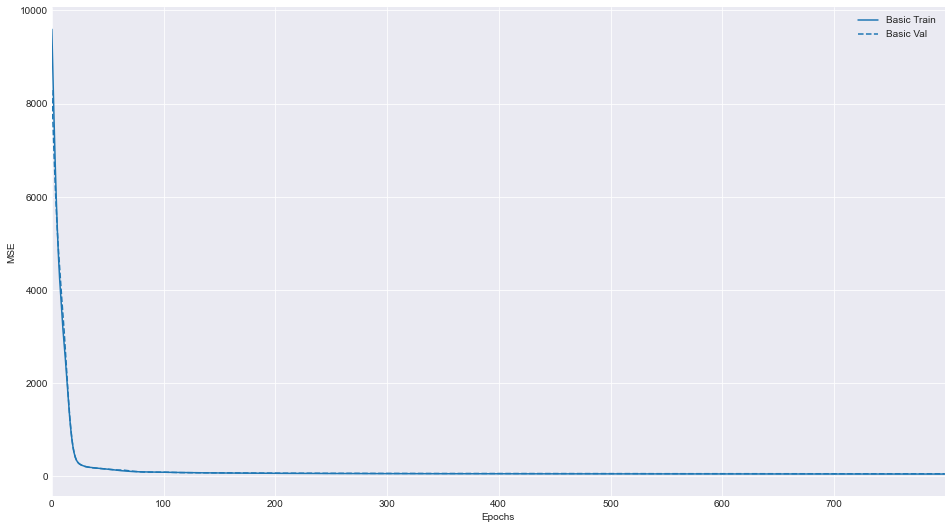

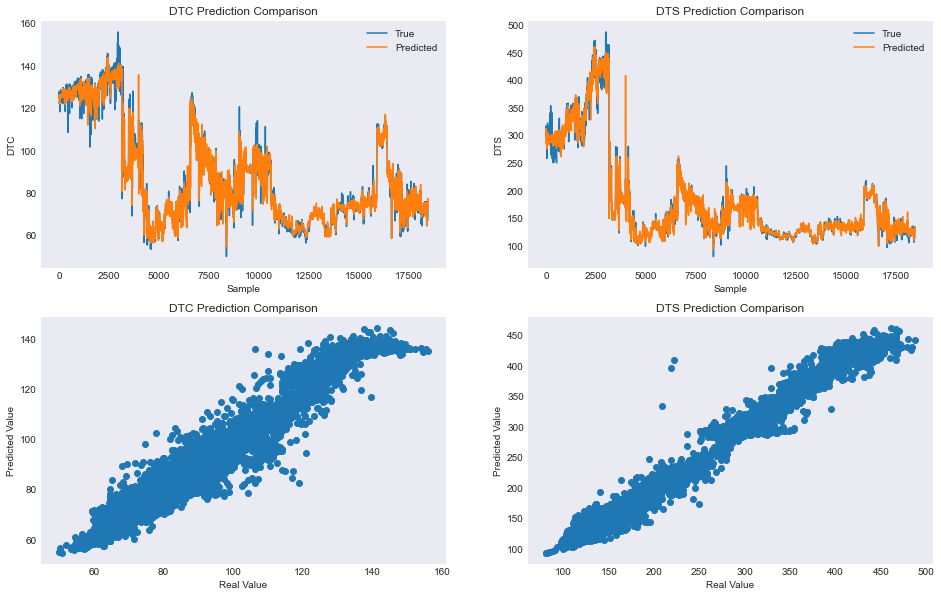

In [86]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mse")
plt.ylabel('MSE')
# plt.ylim([0, 500])

# check the result on train dataset only
train_predictions = model.predict(normed_train_data)
result_plot(np.array(train_predictions), np.array(train_labels))

Root Mean Square Error is: 7.65053


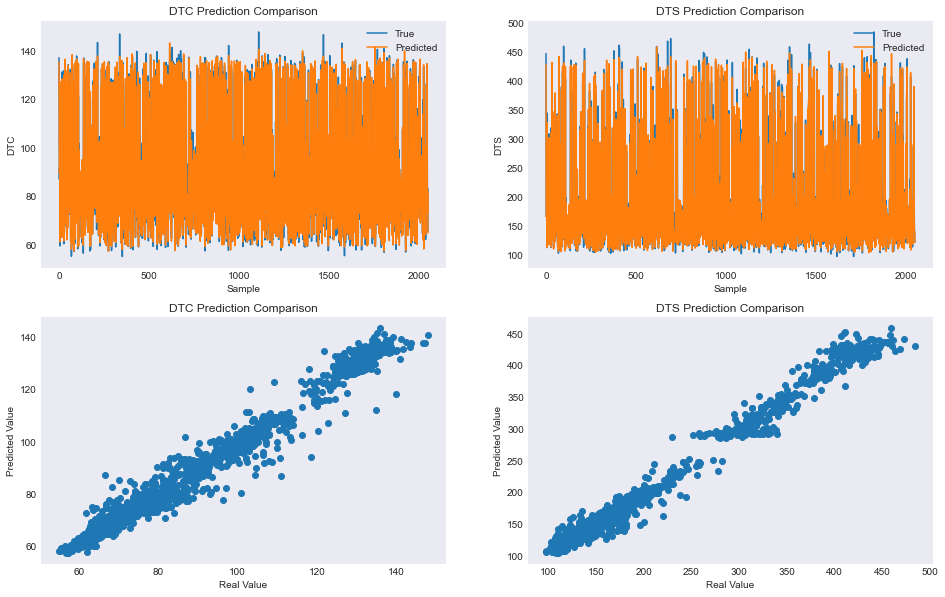

In [87]:
# Predict
test_predictions = model.predict(normed_test_data)

# check the result on test dataset only
result_plot(np.array(test_predictions), np.array(test_labels))

In [ ]:
# # check the result on test dataset only
# result_plot(RF_best.predict(X_test), y_test)

## <a>7. Prediction</a>

<a>Top</a>

In [151]:
# load test data from well 2
df2 = pd.read_csv('test.csv')

print(df2.shape)

# Remove missing 
for col in df2.columns.tolist():
    df2[col][df2[col]==-999] = np.nan

df2.dropna(axis=0, inplace=True)

print(df2.shape)

x_trainwell2 = np.array(norm(df2)).reshape(-1, 7, 1)

y_trainwell2_predict = model.predict(x_trainwell2)

(11088, 7)
(11088, 7)


In [159]:
# load benchmark test data from well 2
df3 = pd.read_csv('real_result_20perc.csv')

index = []
print(len(df2.columns))

# Insert index as depth column
df2_sorted = df2
df2_sorted['IND'] = df2_sorted.index
df2_sorted = df2.sort_values(by=[df2.columns[1]])

def binarySearch(target, v):
    beg, end = 0, len(v)-1
    # print(beg, end)
    
    while beg + 1 < end:
        mid = beg + (end - beg) // 2
        
        # print(target, v[mid])
        if v[mid] < target:
            beg = mid
        else:
            end = mid
    
    #  print(target, v[beg], v[end], beg, end)
    if v[beg] == target:
        return beg
    if v[end] == target:
        return end
    return -999

for i, row in df3.iterrows():
    
    row = row.round(4)
    start = binarySearch(row[1].round(4), df2_sorted[df2.columns[1]].round(4).tolist())
    print('    ', i, start, df2_sorted.iloc[start, 1], row[1])
   
    while df2_sorted.iloc[start, 1].round(4) == row[1]:
        for k in range(len(df2_sorted.columns)-1):
            if row[k] != df2_sorted.iloc[start, k].round(4):
                break
            if k == len(df2_sorted.columns) - 2:
                print(df2_sorted.iloc[start,-1])
                index.append(df2_sorted.iloc[start,-1])
        start += 1

print(df3.iloc[0, :])
print(df2.iloc[index[0], :])
print(len(df3.index), len(index))
if len(df3.index) != len(index):
    raise NameError('index length is wrong!')

8
     0 4857 0.1199 0.1199
5527
     1 10308 0.318 0.318
9325
     2 10297 0.3164 0.3164
317
     3 6767 0.1527 0.1527
8557
     4 7453 0.1731 0.1731
10090
     5 9557 0.2669 0.2669
1055
     6 2854 0.0927 0.0927
4665
     7 8813 0.2331 0.2331
9949
     8 5746 0.1308 0.1308
5290
     9 2864 0.0928 0.0928
3532
     10 9884 0.2815 0.2815
1766
     11 6839 0.1547 0.1547
8663
     12 8573 0.2232 0.2232
9319
     13 10318 0.3199 0.3199
9507
     14 8650 0.2264 0.2264
904
     15 1449 0.0731 0.0731
5185
     16 9860 0.2804 0.2804
986
     17 1966 0.0808 0.0808
4432
     18 1082 0.0675 0.0675
3569
     19 10209 0.3056 0.3056
1003
     20 4349 0.1125 0.1125
6723
     21 9652 0.2707 0.2707
1467
     22 9514 0.2653 0.2653
607
     23 11027 0.4512 0.4512
148
     24 8043 0.2018 0.2018
9300
     25 8037 0.2012 0.2012
539
     26 4052 0.1071 0.1071
4109
     27 5873 0.1326 0.1326
4566
     28 9619 0.2695 0.2695
1804
     29 6817 0.1543 0.1543
4146
     30 10045 0.2907 0.2907
98
     31 10040 0.290

     285 8370 0.2158 0.2158
10783
     286 8562 0.2226 0.2226
9942
     287 10461 0.3403 0.3403
41
     288 3126 0.0959 0.0959
5472
     289 1955 0.0807 0.0807
7075
     290 4303 0.1116 0.1116
8193
     291 7280 0.1677 0.1677
9033
     292 4130 0.1084 0.1084
7649
     293 328 0.0525 0.0525
7399
     294 1056 0.067 0.067
3182
     295 111 0.0446 0.0446
4918
     296 2008 0.0813 0.0813
7363
     297 774 0.0613 0.0613
4527
     298 3463 0.0992 0.0992
6642
     299 6102 0.1365 0.1365
6223
     300 1376 0.0721 0.0721
7365
     301 8850 0.2343 0.2343
898
     302 9312 0.2562 0.2562
417
     303 6097 0.1364 0.1364
6020
     304 9752 0.2758 0.2758
9572
     305 7508 0.175 0.175
9008
     306 4243 0.1102 0.1102
5314
     307 2240 0.085 0.085
2540
     308 3995 0.1063 0.1063
2691
     309 6549 0.1475 0.1475
5772
     310 8949 0.2388 0.2388
846
     311 7062 0.1612 0.1612
2317
     312 1761 0.078 0.078
3676
     313 957 0.0654 0.0654
7448
     314 6020 0.1351 0.1351
8593
     315 10909 0.4146 0.4

2861
     627 2277 0.0855 0.0855
3695
     628 7667 0.1827 0.1827
10416
     629 10952 0.4314 0.4314
9427
     630 8443 0.2178 0.2178
10827
     631 9804 0.2776 0.2776
9569
     632 1323 0.0714 0.0714
4809
     633 2915 0.0935 0.0935
8817
     634 6542 0.1474 0.1474
6098
     635 8829 0.2336 0.2336
9311
     636 8046 0.2019 0.2019
9893
     637 354 0.053 0.053
3107
     638 10728 0.3773 0.3773
1360
     639 9195 0.2515 0.2515
1566
     640 4833 0.1196 0.1196
10900
     641 275 0.0513 0.0513
5036
     642 820 0.0624 0.0624
7544
     643 6407 0.1442 0.1442
4183
     644 2466 0.0878 0.0878
2479
     645 10022 0.2897 0.2897
1140
     646 4598 0.1169 0.1169
4577
     647 7927 0.1967 0.1967
8789
     648 8120 0.2054 0.2054
9934
     649 2963 0.0941 0.0941
5163
     650 10828 0.3962 0.3962
1244
     651 7066 0.1613 0.1613
10004
     652 8370 0.2158 0.2158
9217
     653 5418 0.1269 0.1269
5905
     654 6977 0.1585 0.1585
2043
     655 711 0.0601 0.0601
3499
     656 3107 0.0957 0.0957
2294
   

     903 8485 0.2193 0.2193
10803
     904 1316 0.0712 0.0712
4293
     905 5470 0.1275 0.1275
6256
     906 10728 0.3773 0.3773
1360
     907 8147 0.2062 0.2062
10580
     908 7719 0.1863 0.1863
9917
     909 10670 0.3681 0.3681
666
     910 3635 0.101 0.101
2771
     911 1979 0.0809 0.0809
7946
     912 2224 0.0847 0.0847
3743
     913 5089 0.123 0.123
3874
     914 10430 0.3354 0.3354
1616
     915 7518 0.1755 0.1755
2086
     916 4925 0.1207 0.1207
10355
     917 8734 0.2302 0.2302
449
     918 1898 0.0798 0.0798
7938
     919 1289 0.0708 0.0708
4649
     920 3405 0.0987 0.0987
6406
     921 7711 0.1858 0.1858
10427
     922 2016 0.0814 0.0814
7131
     923 8370 0.2158 0.2158
10831
     924 585 0.0574 0.0574
7432
     925 3765 0.1025 0.1025
5494
     926 8087 0.2039 0.2039
9933
     927 1012 0.0664 0.0664
7185
     928 7158 0.1637 0.1637
4139
     929 2351 0.0864 0.0864
4663
     930 6284 0.1409 0.1409
4274
     931 4946 0.121 0.121
7983
     932 10716 0.3747 0.3747
1361
     933 1

     1162 4035 0.1069 0.1069
6839
     1163 8534 0.2214 0.2214
9131
     1164 3520 0.0998 0.0998
5462
     1165 638 0.0584 0.0584
3260
     1166 4357 0.1126 0.1126
6370
     1167 4207 0.1096 0.1096
5510
     1168 1332 0.0715 0.0715
3393
     1169 8105 0.2048 0.2048
10740
     1170 3297 0.0976 0.0976
6618
     1171 2445 0.0876 0.0876
6472
     1172 10310 0.3184 0.3184
9508
     1173 6261 0.1401 0.1401
8103
     1174 2939 0.0938 0.0938
5241
     1175 8748 0.2306 0.2306
941
     1176 9701 0.2733 0.2733
9980
     1177 10796 0.3899 0.3899
743
     1178 11076 0.4949 0.4949
269
     1179 1202 0.0694 0.0694
3632
     1180 8175 0.2072 0.2072
69
     1181 3732 0.1021 0.1021
8826
     1182 2282 0.0856 0.0856
3545
     1183 7351 0.1699 0.1699
2118
     1184 8510 0.2204 0.2204
10219
     1185 6991 0.1589 0.1589
10697
     1186 5425 0.127 0.127
2679
     1187 2820 0.0923 0.0923
3613
     1188 2618 0.0895 0.0895
7084
     1189 424 0.0545 0.0545
5115
     1190 2905 0.0934 0.0934
4533
     1191 3418 0.

     1418 4093 0.1078 0.1078
6394
     1419 7099 0.1622 0.1622
8964
     1420 4404 0.1139 0.1139
5513
     1421 2481 0.08800000000000001 0.088
5401
     1422 2384 0.0868 0.0868
4393
     1423 6294 0.1411 0.1411
3924
     1424 4714 0.1182 0.1182
3838
     1425 5673 0.1299 0.1299
5288
     1426 1519 0.0742 0.0742
6953
     1427 4588 0.1168 0.1168
3992
     1428 9302 0.256 0.256
1495
     1429 5982 0.1345 0.1345
8354
     1430 2142 0.0836 0.0836
7439
     1431 3202 0.0966 0.0966
2978
     1432 7413 0.1719 0.1719
9292
     1433 3344 0.0981 0.0981
3718
     1434 3333 0.098 0.098
5492
     1435 6978 0.1586 0.1586
2175
     1436 4500 0.1155 0.1155
3726
     1437 8670 0.2272 0.2272
9239
     1438 9981 0.2868 0.2868
9558
     1439 2633 0.0897 0.0897
3230
     1440 9856 0.2803 0.2803
9796
     1441 9195 0.2515 0.2515
1570
     1442 8955 0.2389 0.2389
9613
     1443 2403 0.087 0.087
8863
     1444 4052 0.1071 0.1071
3762
     1445 6001 0.1348 0.1348
6022
     1446 3126 0.0959 0.0959
4418
     144

     1704 5243 0.125 0.125
1330
     1705 10935 0.4252 0.4252
9379
     1706 2670 0.0902 0.0902
6771
     1707 6209 0.139 0.139
8654
     1708 4895 0.1204 0.1204
3994
     1709 7228 0.1659 0.1659
2160
     1710 6496 0.1462 0.1462
8641
     1711 5900 0.1331 0.1331
6253
     1712 8835 0.2339 0.2339
1031
     1713 5720 0.1305 0.1305
5855
     1714 5364 0.1263 0.1263
6263
     1715 5862 0.1325 0.1325
10369
     1716 3635 0.101 0.101
10402
     1717 6943 0.1575 0.1575
9203
     1718 176 0.0477 0.0477
2334
     1719 4008 0.1065 0.1065
3761
     1720 2766 0.0917 0.0917
4537
     1721 10359 0.3255 0.3255
9487
     1722 590 0.0575 0.0575
3469
     1723 54 0.0403 0.0403
4912
     1724 9602 0.2688 0.2688
1491
     1725 2539 0.0886 0.0886
1679
     1726 6798 0.1537 0.1537
8108
     1727 1372 0.07200000000000001 0.072
3402
     1728 1508 0.0741 0.0741
10453
     1729 7453 0.1731 0.1731
10036
     1730 8826 0.2335 0.2335
849
     1731 6949 0.1576 0.1576
10145
     1732 7186 0.1644 0.1644
4140
     1

     2038 6416 0.1445 0.1445
6077
     2039 2786 0.092 0.092
6576
     2040 6732 0.1516 0.1516
8431
     2041 824 0.0625 0.0625
7394
     2042 115 0.0448 0.0448
4905
     2043 3344 0.0981 0.0981
7876
     2044 3457 0.0991 0.0991
8286
     2045 8680 0.2276 0.2276
453
     2046 3248 0.0971 0.0971
8308
     2047 203 0.0486 0.0486
3439
     2048 3155 0.0962 0.0962
6670
     2049 5152 0.1238 0.1238
5920
     2050 3107 0.0957 0.0957
6548
     2051 465 0.0553 0.0553
5064
     2052 4714 0.1182 0.1182
7713
     2053 10786 0.3887 0.3887
1213
     2054 10560 0.3537 0.3537
260
     2055 1774 0.0782 0.0782
4529
     2056 4935 0.1208 0.1208
2873
     2057 1701 0.0771 0.0771
7135
     2058 4753 0.1186 0.1186
5556
     2059 348 0.0529 0.0529
3271
     2060 11070 0.4899 0.4899
268
     2061 814 0.0623 0.0623
7379
     2062 10093 0.2934 0.2934
1230
     2063 6437 0.1451 0.1451
6115
     2064 677 0.0594 0.0594
7916
     2065 5008 0.1218 0.1218
7968
     2066 8324 0.2138 0.2138
72
     2067 5567 0.1286 0.

NameError: index length is wrong!

Root Mean Square Error is: 21.32332


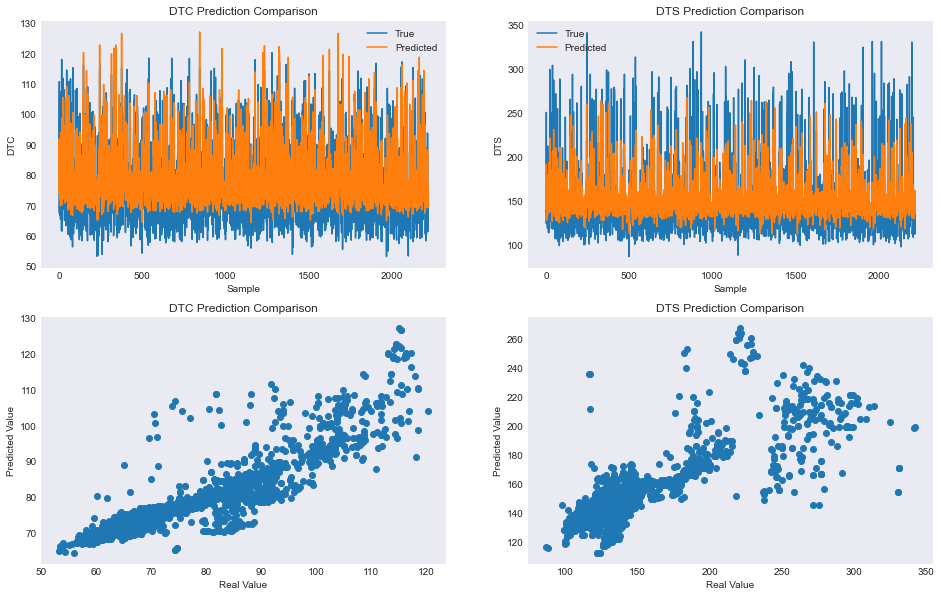

IndexError: boolean index did not match indexed array along dimension 1; dimension is 7 but corresponding boolean dimension is 2

In [88]:
# load benchmark test data from well 2
df3 = pd.read_csv('real_result_20perc.csv')

# Remove missing 
for col in df3.columns.tolist():
    df3[col][df3[col]==-999] = np.nan

# Insert index as depth column
# df3.insert(0, 'DEP', df3.index)
    
df3.dropna(axis=0, inplace=True)

x_trainwell3 = norm(df3.iloc[:,:-2])
y_trainwell3 = df3.iloc[:,-2:]

x_trainwell3 = np.array(x_trainwell3).reshape(-1, 7, 1)
y_trainwell3 = np.array(y_trainwell3)

# print(x_trainwell3[:5][:])

y_trainwell3_predict = model.predict(x_trainwell3)

# check the result
result_plot(np.array(y_trainwell3_predict), np.array(y_trainwell3))

print(x_trainwell3[abs(y_trainwell3_predict) > 400].index)

y_trainwell3_predict2 = np.reshape(y_trainwell3_predict[abs(y_trainwell3_predict) < 400], (-1,2))

print(y_trainwell3_predict2.shape, y_trainwell3.drop(x_trainwell3[abs(y_trainwell3_predict) > 400].index).shape)
print(y_trainwell3_predict2.shape, y_trainwell3.shape)

# check the result
result_plot(np.array(y_trainwell3_predict2), np.array(y_trainwell3.drop(x_trainwell3[abs(y_trainwell3_predict) > 400].index)))

In [ ]:
# run the prediction
well2_predict = RF_best.predict(x_trainwell2)
well2_predict[:5, :]

In [ ]:
# plot the prediction results 
plt.subplots(nrows=1, ncols=2, figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(well2_predict[:, 0])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTC')
plt.title('DTC Prediction Comparison')

plt.subplot(1, 2, 2)
plt.plot(well2_predict[:, 1])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTS')
plt.title('DTS Prediction Comparison')
plt.show()

In [ ]:
# load benchmark test data from well 2
df3 = pd.read_csv('real_result_20perc.csv')

# Remove missing 
for col in df3.columns.tolist():
    df3[col][df3[col]==-999] = np.nan

# Insert index as depth column
# df3.insert(0, 'DEP', df3.index)
    
df3.dropna(axis=0, inplace=True)

x_trainwell3 = norm(df3.iloc[:,:-2])
y_trainwell3 = df3.iloc[:,-2:]

print(x_trainwell3[:5][:])

# check the result
result_plot(np.array(model.predict(x_trainwell3)), np.array(y_trainwell3))

In [ ]:
# check if there's any co-linearity between features
plt.scatter(df1['DTC'], df1['DTS'], s=20, alpha=0.2)
plt.scatter(df3['DTC'], df3['DTS'], s=20, alpha=0.5)

In [ ]:
output_result = pd.DataFrame({'DTC':well2_predict[:,0], 'DTS':well2_predict[:,1]})
output_result.head()

In [ ]:
#output_result.to_csv(path_or_buf='./sample_submission.csv', index=False)
output_result.to_csv(path_or_buf='./sample_submission2_19.csv', index=False)

## <a>8. Summary</a>

<a>Top</a>

Put your ideas, findings, insights, suggestions, and references here